<a href="https://colab.research.google.com/github/ValentinGuigon/Neuromatch_Deep_Learning_tutorials/blob/main/tutorials/W1D2_LinearDeepLearning/student/W1D2_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 3: Deep linear neural networks
**Week 1, Day 2: Linear Deep Learning**

**By Neuromatch Academy**

__Content creators:__ Saeed Salehi, Spiros Chavlis, Andrew Saxe

__Content reviewers:__ Polina Turishcheva, Antoine De Comite

__Content editors:__ Anoop Kulkarni

__Production editors:__ Khalid Almubarak, Gagana B, Spiros Chavlis

---
# Tutorial Objectives

* Deep linear neural networks
* Learning dynamics and singular value decomposition
* Representational Similarity Analysis
* Illusory correlations & ethics

In [26]:
# @title Tutorial slides
from IPython.display import IFrame
link_id = "bncr8"
print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

If you want to download the slides: https://osf.io/download/bncr8/


---
# Setup

This a GPU-Free tutorial!

In [30]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_dl",
            "user_key": "f379rz8y",
        },
    ).render()


feedback_prefix = "W1D2_T3"

In [31]:
# Imports
import math
import torch
import matplotlib

import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim

In [32]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

from matplotlib import gridspec
from ipywidgets import interact, IntSlider, FloatSlider, fixed
from ipywidgets import FloatLogSlider, Layout, VBox
from ipywidgets import interactive_output
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [33]:
# @title Plotting functions

def plot_x_y_hier_data(im1, im2, subplot_ratio=[1, 2]):
  """
  Plot hierarchical data of labels vs features
  for all samples

  Args:
    im1: np.ndarray
      Input Dataset
    im2: np.ndarray
      Targets
    subplot_ratio: list
      Subplot ratios used to create subplots of varying sizes

  Returns:
    Nothing
  """
  fig = plt.figure(figsize=(12, 5))
  gs = gridspec.GridSpec(1, 2, width_ratios=subplot_ratio)
  ax0 = plt.subplot(gs[0])
  ax1 = plt.subplot(gs[1])
  ax0.imshow(im1, cmap="cool")
  ax1.imshow(im2, cmap="cool")
  ax0.set_title("Labels of all samples")
  ax1.set_title("Features of all samples")
  ax0.set_axis_off()
  ax1.set_axis_off()
  plt.tight_layout()
  plt.show()


def plot_x_y_hier_one(im1, im2, subplot_ratio=[1, 2]):
  """
  Plot hierarchical data of labels vs features
  for a single sample

  Args:
    im1: np.ndarray
      Input Dataset
    im2: np.ndarray
      Targets
    subplot_ratio: list
      Subplot ratios used to create subplots of varying sizes

  Returns:
    Nothing
  """
  fig = plt.figure(figsize=(12, 1))
  gs = gridspec.GridSpec(1, 2, width_ratios=subplot_ratio)
  ax0 = plt.subplot(gs[0])
  ax1 = plt.subplot(gs[1])
  ax0.imshow(im1, cmap="cool")
  ax1.imshow(im2, cmap="cool")
  ax0.set_title("Labels of a single sample")
  ax1.set_title("Features of a single sample")
  ax0.set_axis_off()
  ax1.set_axis_off()
  plt.tight_layout()
  plt.show()


def plot_tree_data(label_list = None, feature_array = None, new_feature = None):
  """
  Plot tree data

  Args:
    label_list: np.ndarray
      List of labels [default: None]
    feature_array: np.ndarray
      List of features [default: None]
    new_feature: string
      Enables addition of new features

  Returns:
    Nothing
  """
  cmap = matplotlib.colors.ListedColormap(['cyan', 'magenta'])
  n_features = 10
  n_labels = 8
  im1 = np.eye(n_labels)
  if feature_array is None:
    im2 = np.array([[1, 1, 1, 1, 1, 1, 1, 1],
                      [0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 1, 1, 1, 1],
                      [1, 1, 1, 1, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 1, 1],
                      [0, 0, 1, 1, 0, 0, 0, 0],
                      [1, 1, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 1, 1, 0, 0],
                      [0, 1, 1, 1, 0, 0, 0, 0],
                      [0, 0, 0, 0, 1, 1, 0, 1]]).T
    im2[im2 == 0] = -1
    feature_list = ['can_grow',
                    'is_mammal',
                    'has_leaves',
                    'can_move',
                    'has_trunk',
                    'can_fly',
                    'can_swim',
                    'has_stem',
                    'is_warmblooded',
                    'can_flower']
  else:
    im2 = feature_array
  if label_list is None:
    label_list = ['Goldfish', 'Tuna', 'Robin', 'Canary',
                  'Rose', 'Daisy', 'Pine', 'Oak']
  fig = plt.figure(figsize=(12, 7))
  gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.35])
  ax1 = plt.subplot(gs[0])
  ax2 = plt.subplot(gs[1])
  ax1.imshow(im1, cmap=cmap)
  if feature_array is None:
    implt = ax2.imshow(im2, cmap=cmap, vmin=-1.0, vmax=1.0)
  else:
    implt = ax2.imshow(im2[:, -n_features:], cmap=cmap, vmin=-1.0, vmax=1.0)
  divider = make_axes_locatable(ax2)
  cax = divider.append_axes("right", size="5%", pad=0.1)
  cbar = plt.colorbar(implt, cax=cax, ticks=[-0.5, 0.5])
  cbar.ax.set_yticklabels(['no', 'yes'])
  ax1.set_title("Labels")
  ax1.set_yticks(ticks=np.arange(n_labels))
  ax1.set_yticklabels(labels=label_list)
  ax1.set_xticks(ticks=np.arange(n_labels))
  ax1.set_xticklabels(labels=label_list, rotation='vertical')
  ax2.set_title("{} random Features".format(n_features))
  ax2.set_yticks(ticks=np.arange(n_labels))
  ax2.set_yticklabels(labels=label_list)
  if feature_array is None:
    ax2.set_xticks(ticks=np.arange(n_features))
    ax2.set_xticklabels(labels=feature_list, rotation='vertical')
  else:
    ax2.set_xticks(ticks=[n_features-1])
    ax2.set_xticklabels(labels=[new_feature], rotation='vertical')
  plt.tight_layout()
  plt.show()


def plot_loss(loss_array,
              title="Training loss (Mean Squared Error)",
              c="r"):
  """
  Plot loss function

  Args:
    c: string
      Specifies plot color
    title: string
      Specifies plot title
    loss_array: np.ndarray
      Log of MSE loss per epoch

  Returns:
    Nothing
  """
  plt.figure(figsize=(10, 5))
  plt.plot(loss_array, color=c)
  plt.xlabel("Epoch")
  plt.ylabel("MSE")
  plt.title(title)
  plt.show()


def plot_loss_sv(loss_array, sv_array):
  """
  Plot loss function

  Args:
    sv_array: np.ndarray
      Log of singular values/modes across epochs
    loss_array: np.ndarray
      Log of MSE loss per epoch

  Returns:
    Nothing
  """
  n_sing_values = sv_array.shape[1]
  sv_array = sv_array / np.max(sv_array)
  cmap = plt.cm.get_cmap("Set1", n_sing_values)

  _, (plot1, plot2) = plt.subplots(2, 1, sharex=True, figsize=(10, 10))
  plot1.set_title("Training loss (Mean Squared Error)")
  plot1.plot(loss_array, color='r')

  plot2.set_title("Evolution of singular values (modes)")
  for i in range(n_sing_values):
    plot2.plot(sv_array[:, i], c=cmap(i))
  plot2.set_xlabel("Epoch")
  plt.show()


def plot_loss_sv_twin(loss_array, sv_array):
  """
  Plot learning dynamics

  Args:
    sv_array: np.ndarray
      Log of singular values/modes across epochs
    loss_array: np.ndarray
      Log of MSE loss per epoch

  Returns:
    Nothing
  """
  n_sing_values = sv_array.shape[1]
  sv_array = sv_array / np.max(sv_array)
  cmap = plt.cm.get_cmap("winter", n_sing_values)

  fig = plt.figure(figsize=(10, 5))
  ax1 = plt.gca()
  ax1.set_title("Learning Dynamics")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Mean Squared Error", c='r')
  ax1.tick_params(axis='y', labelcolor='r')
  ax1.plot(loss_array, color='r')

  ax2 = ax1.twinx()
  ax2.set_ylabel("Singular values (modes)", c='b')
  ax2.tick_params(axis='y', labelcolor='b')
  for i in range(n_sing_values):
    ax2.plot(sv_array[:, i], c=cmap(i))

  fig.tight_layout()
  plt.show()


def plot_ills_sv_twin(ill_array, sv_array, ill_label):
  """
  Plot network training evolution
  and illusory correlations

  Args:
    sv_array: np.ndarray
      Log of singular values/modes across epochs
    ill_array: np.ndarray
      Log of illusory correlations per epoch
    ill_label: np.ndarray
      Log of labels associated with illusory correlations

  Returns:
    Nothing
  """
  n_sing_values = sv_array.shape[1]
  sv_array = sv_array / np.max(sv_array)
  cmap = plt.cm.get_cmap("winter", n_sing_values)

  fig = plt.figure(figsize=(10, 5))
  ax1 = plt.gca()
  ax1.set_title("Network training and the Illusory Correlations")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel(ill_label, c='r')
  ax1.tick_params(axis='y', labelcolor='r')
  ax1.plot(ill_array, color='r', linewidth=3)
  ax1.set_ylim(-1.05, 1.05)

  ax2 = ax1.twinx()
  ax2.set_ylabel("Singular values (modes)", c='b')
  ax2.tick_params(axis='y', labelcolor='b')
  for i in range(n_sing_values):
    ax2.plot(sv_array[:, i], c=cmap(i))

  fig.tight_layout()
  plt.show()


def plot_loss_sv_rsm(loss_array, sv_array, rsm_array, i_ep):
  """
  Plot learning dynamics

  Args:
    sv_array: np.ndarray
      Log of singular values/modes across epochs
    loss_array: np.ndarray
      Log of MSE loss per epoch
    rsm_array: torch.tensor
      Representation similarity matrix
    i_ep: int
      Which epoch to show

  Returns:
    Nothing
  """
  n_ep = loss_array.shape[0]
  rsm_array = rsm_array / np.max(rsm_array)
  sv_array = sv_array / np.max(sv_array)

  n_sing_values = sv_array.shape[1]
  cmap = plt.cm.get_cmap("winter", n_sing_values)

  fig = plt.figure(figsize=(14, 5))
  gs = gridspec.GridSpec(1, 2, width_ratios=[5, 3])

  ax0 = plt.subplot(gs[1])
  ax0.yaxis.tick_right()
  implot = ax0.imshow(rsm_array[i_ep], cmap="Purples", vmin=0.0, vmax=1.0)
  divider = make_axes_locatable(ax0)
  cax = divider.append_axes("right", size="5%", pad=0.9)
  cbar = plt.colorbar(implot, cax=cax, ticks=[])
  cbar.ax.set_ylabel('Similarity', fontsize=12)
  ax0.set_title("RSM at epoch {}".format(i_ep), fontsize=16)
  ax0.set_yticks(ticks=np.arange(n_sing_values))
  ax0.set_yticklabels(labels=item_names)
  ax0.set_xticks(ticks=np.arange(n_sing_values))
  ax0.set_xticklabels(labels=item_names, rotation='vertical')

  ax1 = plt.subplot(gs[0])
  ax1.set_title("Learning Dynamics", fontsize=16)
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Mean Squared Error", c='r')
  ax1.tick_params(axis='y', labelcolor='r', direction="in")
  ax1.plot(np.arange(n_ep), loss_array, color='r')
  ax1.axvspan(i_ep-2, i_ep+2, alpha=0.2, color='m')

  ax2 = ax1.twinx()
  ax2.set_ylabel("Singular values", c='b')
  ax2.tick_params(axis='y', labelcolor='b', direction="in")
  for i in range(n_sing_values):
    ax2.plot(np.arange(n_ep), sv_array[:, i], c=cmap(i))
  ax1.set_xlim(-1, n_ep+1)
  ax2.set_xlim(-1, n_ep+1)

  plt.show()

In [34]:
# @title Helper functions

def build_tree(n_levels, n_branches, probability,
               to_np_array=True):
  """
  Builds tree

  Args:
    n_levels: int
      Number of levels in tree
    n_branches: int
      Number of branches in tree
    probability: float
      Flipping probability
    to_np_array: boolean
      If true, represent tree as np.ndarray

  Returns:
    tree: dict if to_np_array=False
          np.ndarray otherwise
      Tree
  """
  assert 0.0 <= probability <= 1.0

  tree = {}

  tree["level"] = [0]
  for i in range(1, n_levels+1):
    tree["level"].extend([i]*(n_branches**i))

  tree["pflip"] = [probability]*len(tree["level"])

  tree["parent"] = [None]
  k = len(tree["level"])-1
  for j in range(k//n_branches):
    tree["parent"].extend([j]*n_branches)

  if to_np_array:
    tree["level"] = np.array(tree["level"])
    tree["pflip"] = np.array(tree["pflip"])
    tree["parent"] = np.array(tree["parent"])

  return tree


def sample_from_tree(tree, n):
  """
  Generates n samples from a tree

  Args:
    tree: np.ndarray/dictionary
      Tree
    n: int
      Number of levels in tree

  Returns:
    x: np.ndarray
      Sample from tree
  """
  items = [i for i, v in enumerate(tree["level"]) if v == max(tree["level"])]
  n_items = len(items)
  x = np.zeros(shape=(n, n_items))
  rand_temp = np.random.rand(n, len(tree["pflip"]))
  flip_temp = np.repeat(tree["pflip"].reshape(1, -1), n, 0)
  samp = (rand_temp > flip_temp) * 2 - 1

  for i in range(n_items):
    j = items[i]
    prop = samp[:, j]
    while tree["parent"][j] is not None:
      j = tree["parent"][j]
      prop = prop * samp[:, j]
    x[:, i] = prop.T
  return x


def generate_hsd():
  """
  Building the tree

  Args:
    None

  Returns:
    tree_labels: np.ndarray
      Tree Labels
    tree_features: np.ndarray
      Sample from tree
  """
  n_branches = 2  # 2 branches at each node
  probability = .15  # flipping probability
  n_levels = 3  # number of levels (depth of tree)
  tree = build_tree(n_levels, n_branches, probability, to_np_array=True)
  tree["pflip"][0] = 0.5
  n_samples = 10000 # Sample this many features

  tree_labels = np.eye(n_branches**n_levels)
  tree_features = sample_from_tree(tree, n_samples).T
  return tree_labels, tree_features


def linear_regression(X, Y):
  """
  Analytical Linear regression

  Args:
    X: np.ndarray
      Input features
    Y: np.ndarray
      Targets

  Returns:
    W: np.ndarray
      Analytical solution
      W = Y @ X.T @ np.linalg.inv(X @ X.T)
  """
  assert isinstance(X, np.ndarray)
  assert isinstance(Y, np.ndarray)
  M, Dx = X.shape
  N, Dy = Y.shape
  assert Dx == Dy
  W = Y @ X.T @ np.linalg.inv(X @ X.T)
  return W


def add_feature(existing_features, new_feature):
  """
  Adding new features to existing tree

  Args:
    existing_features: np.ndarray
      List of features already present in the tree
    new_feature: list
      List of new features to be added

  Returns:
    New features augmented with existing features
  """
  assert isinstance(existing_features, np.ndarray)
  assert isinstance(new_feature, list)
  new_feature = np.array([new_feature]).T
  return np.hstack((tree_features, new_feature))


def net_svd(model, in_dim):
  """
  Performs a Singular Value Decomposition on
  given model weights

  Args:
    model: torch.nn.Module
      Neural network model
    in_dim: int
      The input dimension of the model

  Returns:
    U: torch.tensor
      Orthogonal Matrix
    Σ: torch.tensor
      Diagonal Matrix
    V: torch.tensor
      Orthogonal Matrix
  """
  W_tot = torch.eye(in_dim)
  for weight in model.parameters():
    W_tot = weight.detach() @ W_tot
  U, SIGMA, V = torch.svd(W_tot)
  return U, SIGMA, V


def net_rsm(h):
  """
  Calculates the Representational Similarity Matrix

  Args:
    h: torch.Tensor
      Activity of a hidden layer

  Returns:
    rsm: torch.Tensor
      Representational Similarity Matrix
  """
  rsm = h @ h.T
  return rsm


def initializer_(model, gamma=1e-12):
  """
  In-place Re-initialization of weights

  Args:
    model: torch.nn.Module
      PyTorch neural net model
    gamma: float
      Initialization scale

  Returns:
    Nothing
  """
  for weight in model.parameters():
    n_out, n_in = weight.shape
    sigma = gamma / math.sqrt(n_in + n_out)
    nn.init.normal_(weight, mean=0.0, std=sigma)


def test_initializer_ex(seed):
  """
  Testing initializer implementation

  Args:
    seed: int
      Set for reproducibility

  Returns:
    Nothing
  """
  torch.manual_seed(seed)
  model = LNNet(5000, 5000, 1)
  try:
    ex_initializer_(model, gamma=1)
    std = torch.std(next(iter(model.parameters())).detach()).item()
    if -1e-5 <= (std - 0.01) <= 1e-5:
      print("Well done! Seems to be correct!")
    else:
      print("Please double check your implementation!")
  except:
    print("Faulty Implementation!")


def test_net_svd_ex(seed):
  """
  Tests net_svd_ex exercise

  Args:
    seed: int
      Set for reproducibility

  Returns:
    Nothing
  """
  torch.manual_seed(seed)
  model = LNNet(8, 30, 100)
  try:
    U_ex, Σ_ex, V_ex = ex_net_svd(model, 8)
    U, Σ, V = net_svd(model, 8)
    if (torch.all(torch.isclose(U_ex.detach(), U.detach(), atol=1e-6)) and
        torch.all(torch.isclose(Σ_ex.detach(), Σ.detach(), atol=1e-6)) and
        torch.all(torch.isclose(V_ex.detach(), V.detach(), atol=1e-6))):
      print("Well done! Seems to be correct!")
    else:
      print("Please double check your implementation!")
  except:
    print("Faulty Implementation!")


def test_net_rsm_ex(seed):
  """
  Tests net_rsm_ex implementation

  Args:
    seed: int
      Set for reproducibility

  Returns:
    Nothing
  """
  torch.manual_seed(seed)
  x = torch.rand(7, 17)
  try:
    y_ex = ex_net_rsm(x)
    y = x @ x.T
    if (torch.all(torch.isclose(y_ex, y, atol=1e-6))):
      print("Well done! Seems to be correct!")
    else:
      print("Please double check your implementation!")
  except:
    print("Faulty Implementation!")

In [35]:
#@title Set random seed

#@markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [36]:
#@title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [37]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


This colab notebook is GPU free!

---
# Section 0: Prelude
*Time estimate: ~10 mins*



**A note on the exercises**: Most of the exercises are marked `Optional(Bonus)` and should only read through them if you are in a tight timeline. Therefore we would not rely on the implementation of the exercises. If necessary, you can look at the *Helper Functions* cell above to find the functions and classes used in this tutorial.

Throughout this tutorial, we will use a linear neural net with a single hidden layer. We have also excluded `bias` from the layers. Please note that the forward loop returns the hidden activation, besides the network output (prediction). we will need it in section 3.

In [38]:
class LNNet(nn.Module):
  """
  A Linear Neural Net with one hidden layer
  """

  def __init__(self, in_dim, hid_dim, out_dim):
    """
    Initialize LNNet parameters

    Args:
      in_dim: int
        Input dimension
      out_dim: int
        Ouput dimension
      hid_dim: int
        Hidden dimension

    Returns:
      Nothing
    """
    super().__init__()
    self.in_hid = nn.Linear(in_dim, hid_dim, bias=False)
    self.hid_out = nn.Linear(hid_dim, out_dim, bias=False)

  def forward(self, x):
    """
    Forward pass of LNNet

    Args:
      x: torch.Tensor
        Input tensor

    Returns:
      hid: torch.Tensor
        Hidden layer activity
      out: torch.Tensor
        Output/Prediction
    """
    hid = self.in_hid(x)  # Hidden activity
    out = self.hid_out(hid)  # Output (prediction)
    return out, hid

Other than `net_svd` and `net_rsm` functions, the training loop should be mostly familiar to you. We will define these functions in the coming sections.

**Important**: Please note that the two functions are part of inner training loop and are therefore executed and recorded at every iteration.

In [39]:
def train(model, inputs, targets, n_epochs, lr, illusory_i=0):
  """
  Training function

  Args:
    model: torch nn.Module
      The neural network
    inputs: torch.Tensor
      Features (input) with shape `[batch_size, input_dim]`
    targets: torch.Tensor
      Targets (labels) with shape `[batch_size, output_dim]`
    n_epochs: int
      Number of training epochs (iterations)
    lr: float
      Learning rate
    illusory_i: int
      Index of illusory feature

  Returns:
    losses: np.ndarray
      Record (evolution) of training loss
    modes: np.ndarray
      Record (evolution) of singular values (dynamic modes)
    rs_mats: np.ndarray
      Record (evolution) of representational similarity matrices
    illusions: np.ndarray
      Record of network prediction for the last feature
  """
  in_dim = inputs.size(1)

  losses = np.zeros(n_epochs)  # Loss records
  modes = np.zeros((n_epochs, in_dim))  # Singular values (modes) records
  rs_mats = []  # Representational similarity matrices
  illusions = np.zeros(n_epochs)  # Prediction for the given feature

  optimizer = optim.SGD(model.parameters(), lr=lr)
  criterion = nn.MSELoss()

  for i in range(n_epochs):
    optimizer.zero_grad()
    predictions, hiddens = model(inputs)
    loss = criterion(predictions, targets)
    loss.backward()
    optimizer.step()

    # Section 2 Singular value decomposition
    U, Σ, V = net_svd(model, in_dim)

    # Section 3 calculating representational similarity matrix
    RSM = net_rsm(hiddens.detach())

    # Section 4 network prediction of illusory_i inputs for the last feature
    pred_ij = predictions.detach()[illusory_i, -1]

    # Logging (recordings)
    losses[i] = loss.item()
    modes[i] = Σ.detach().numpy()
    rs_mats.append(RSM.numpy())
    illusions[i] = pred_ij.numpy()

  return losses, modes, np.array(rs_mats), illusions

We also need take over the initialization of the weights. In PyTorch, [`nn.init`](https://pytorch.org/docs/stable/nn.init.html) provides us with the functions to initialize tensors from a given distribution.

## Coding Exercise 0: Re-initialization (Optional)

Complete the function `ex_initializer_`, such that the weights are sampled from the following distribution:

\begin{equation}
\mathcal{N}\left(\mu=0, ~~\sigma=\gamma \sqrt{\dfrac{1}{n_{in} + n_{out}}} \right)
\end{equation}

where $\gamma$ is the initialization scale, $n_{in}$ and $n_{out}$ are respectively input and output dimensions of the layer. the Underscore ("_") in `ex_initializer_` and other functions, denotes "[in-place](https://discuss.pytorch.org/t/what-is-in-place-operation/16244/2)" operation.

**important note**: Since we did not include bias in the layers, the `model.parameters()` would only return the weights in each layer.

In [40]:
def ex_initializer_(model, gamma=1e-12):
  """
  In-place Re-initialization of weights

  Args:
    model: torch.nn.Module
      PyTorch neural net model
    gamma: float
      Initialization scale

  Returns:
    Nothing
  """
  for weight in model.parameters():
    n_out, n_in = weight.shape
    sigma = gamma / math.sqrt(n_in + n_out)
    nn.init.normal_(weight, mean=0.0, std=sigma)

## uncomment and run
test_initializer_ex(SEED)

Well done! Seems to be correct!


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W1D2_LinearDeepLearning/solutions/W1D2_Tutorial3_Solution_8291e408.py)



---
# Section 1: Deep Linear Neural Nets

*Time estimate: ~20 mins*

In [41]:
# @title Video 1: Intro to Representation Learning
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'DqMSU4Bikt0'), ('Bilibili', 'BV1iM4y1T7eJ')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

So far, depth just seems to slow down the learning. And we know that a single nonlinear hidden layer (given enough number of neurons and infinite training samples) has the potential to approximate any function. So it seems fair to ask: **What is depth good for**?

One reason can be that shallow nonlinear neural networks hardly meet their true potential in practice. In the contrast, deep neural nets are often surprisingly powerful in learning complex functions without sacrificing generalization. A core intuition behind deep learning is that deep nets derive their power through learning internal representations. How does this work? To address representation learning, we have to go beyond the 1D chain.

For this and the next couple of exercises, we use syntactically generated hierarchically structured data through a *branching diffusion process* (see [this reference](https://www.pnas.org/content/pnas/suppl/2019/05/16/1820226116.DCSupplemental/pnas.1820226116.sapp.pdf) for more details).

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W1D2_LinearDeepLearning/static/tree.png" alt="Simple nn graph" width="600"/></center>

<center> hierarchically structured data (a tree) </center>

The inputs to the network are labels (i.e. names), while the outputs are the features (i.e. attributes). For example, for the label "Goldfish", the network has to learn all the (artificially created) features, such as "*can swim*", "*is cold-blooded*", "*has fins*", and more. Given that we are training on hierarchically structured data, network could also learn the tree structure, that Goldfish and Tuna have rather similar features, and Robin has more in common with Tuna, compared to Rose.

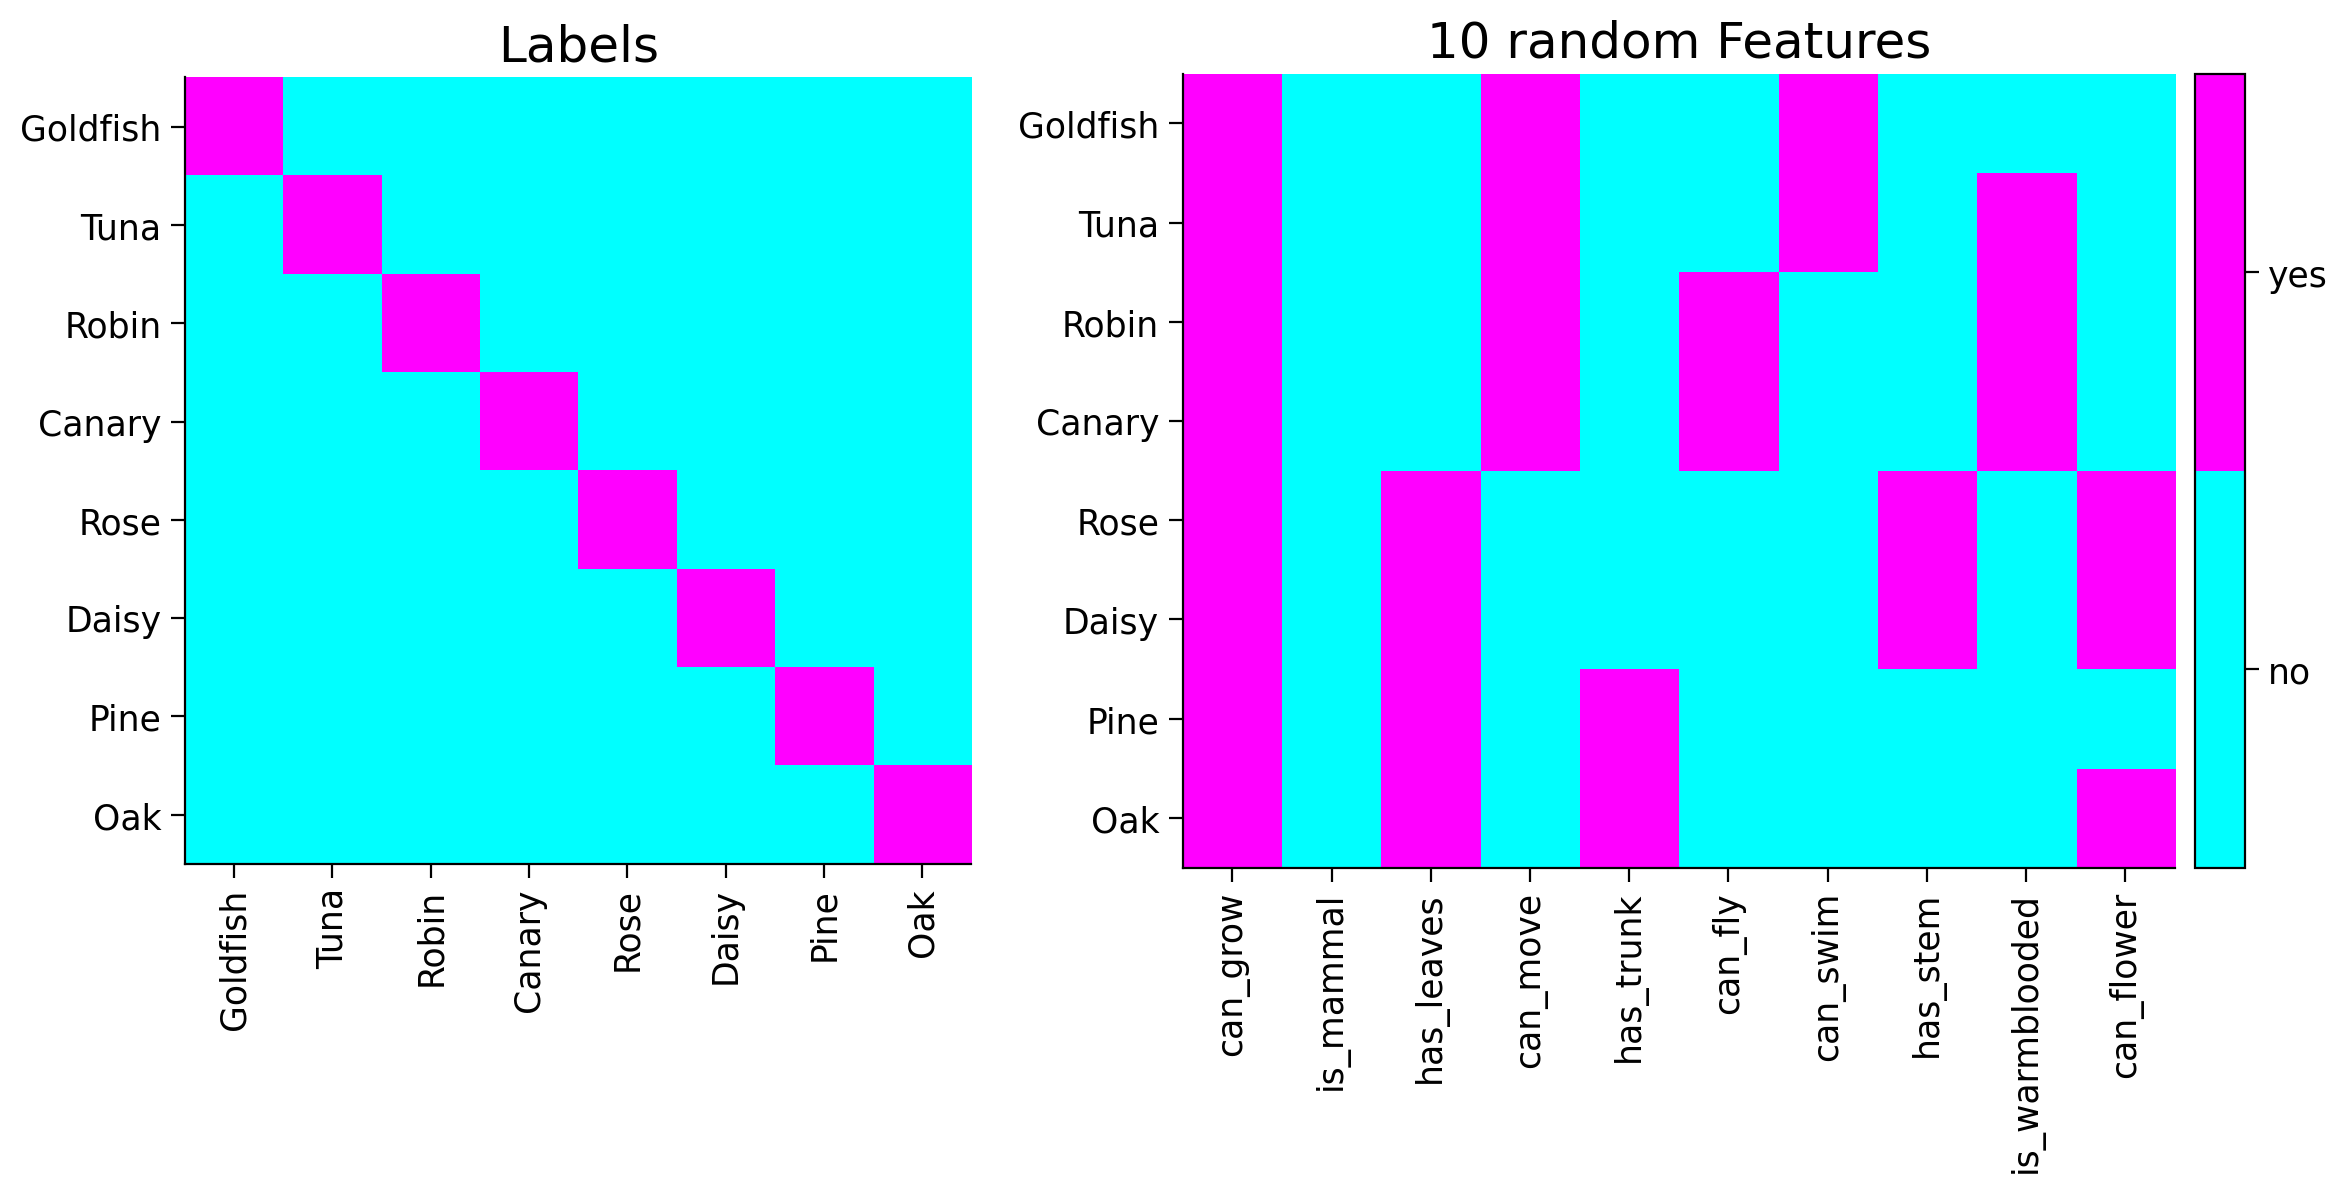

---------------------------------------------------------------
Input Dimension: 8
Output Dimension: 10000
Number of samples: 8


In [42]:
# @markdown #### Run to generate and visualize training samples from tree

tree_labels, tree_features = generate_hsd()

# Convert (cast) data from np.ndarray to torch.Tensor
label_tensor = torch.tensor(tree_labels).float()
feature_tensor = torch.tensor(tree_features).float()

item_names = ['Goldfish', 'Tuna', 'Robin', 'Canary',
              'Rose', 'Daisy', 'Pine', 'Oak']
plot_tree_data()

# Dimensions
print("---------------------------------------------------------------")
print("Input Dimension: {}".format(tree_labels.shape[1]))
print("Output Dimension: {}".format(tree_features.shape[1]))
print("Number of samples: {}".format(tree_features.shape[0]))

To continue this tutorial, it is vital to understand the premise of our training data and what the task is. Therefore, please take your time to discuss them with your pod.

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W1D2_LinearDeepLearning/static/neural_net.png" alt="neural net" width="600"/></center>

<center> The neural network used for this tutorial </center>

## Interactive Demo 1: Training the deep LNN

Training a neural net on our data is straight forward. But before executing the next cell, remember the training loss curve from previous tutorial.

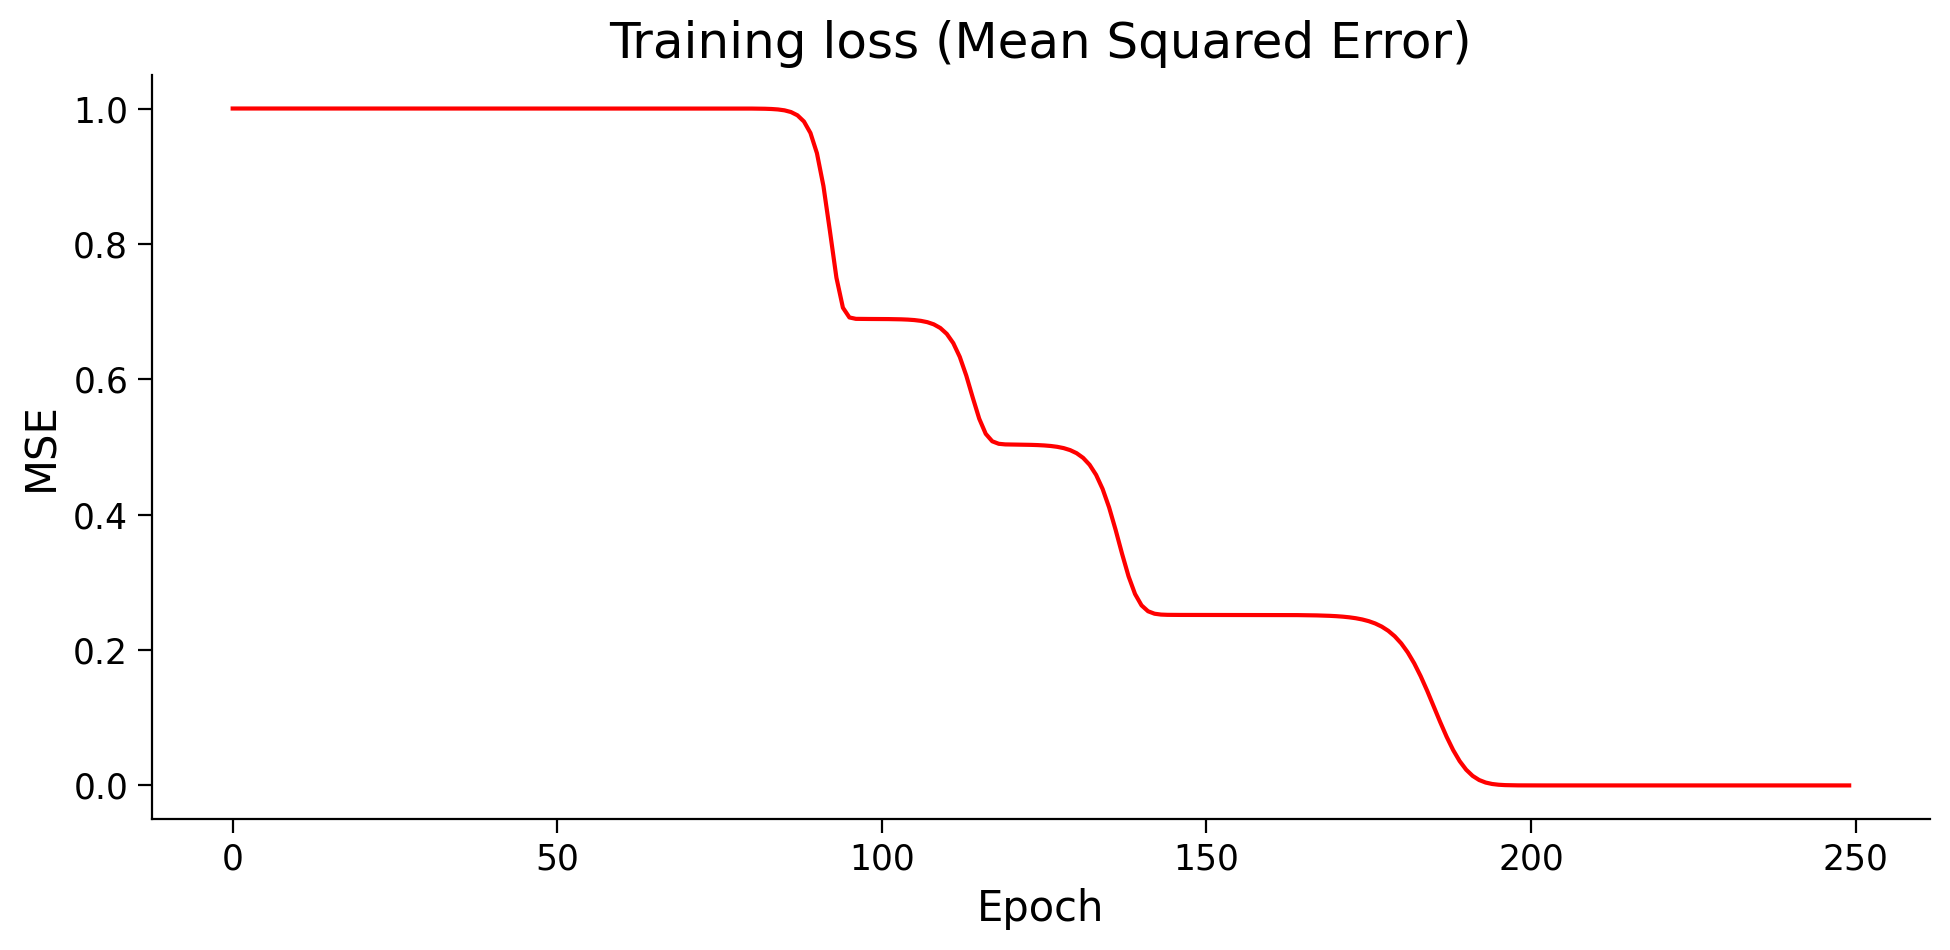

In [43]:
# @markdown #### Make sure you execute this cell to train the network and plot

lr = 100.0  # Learning rate
gamma = 1e-12  # Initialization scale
n_epochs = 250  # Number of epochs
dim_input = 8  # Input dimension = `label_tensor.size(1)`
dim_hidden = 30  # Hidden neurons
dim_output = 10000  # Output dimension = `feature_tensor.size(1)`

# Model instantiation
dlnn_model = LNNet(dim_input, dim_hidden, dim_output)

# Weights re-initialization
initializer_(dlnn_model, gamma)

# Training
losses, *_ = train(dlnn_model,
                  label_tensor,
                  feature_tensor,
                  n_epochs=n_epochs,
                  lr=lr)

# Plotting
plot_loss(losses)

**Think!**

Why haven't we seen these "bumps" in training before? And should we look for them in the future? What do these bumps mean?

Recall from previous tutorial, that we are always interested in learning rate ($\eta$) and initialization ($\gamma$) that would give us the fastest but yet stable (reliable) convergence. Try finding the optimal $\eta$ and $\gamma$ using the following widgets. More specifically, try large $\gamma$ and see if we can recover the bumps by tuning the $\eta$.

In [44]:
# @markdown #### Make sure you execute this cell to enable the widget!

def loss_lr_init(lr, gamma):
  """
  Trains and plots the loss evolution

  Args:
    lr: float
      Learning rate
    gamma: float
      Initialization scale

  Returns:
    Nothing
  """
  n_epochs = 250  # Number of epochs
  dim_input = 8  # Input dimension = `label_tensor.size(1)`
  dim_hidden = 30  # Hidden neurons
  dim_output = 10000  # Output dimension = `feature_tensor.size(1)`

  # Model instantiation
  dlnn_model = LNNet(dim_input, dim_hidden, dim_output)

  # Weights re-initialization
  initializer_(dlnn_model, gamma)

  losses, *_ = train(dlnn_model,
                    label_tensor,
                    feature_tensor,
                    n_epochs=n_epochs,
                    lr=lr)

  plot_loss(losses)

_ = interact(loss_lr_init,
             lr = FloatSlider(min=1.0, max=200.0,
                              step=1.0, value=100.0,
                              continuous_update=False,
                              readout_format='.1f',
                              description='eta'),
             epochs = fixed(250),
             gamma = FloatLogSlider(min=-15, max=1,
                                    step=1, value=1e-12, base=10,
                                    continuous_update=False,
                                    description='gamma')
             )

interactive(children=(FloatSlider(value=100.0, continuous_update=False, description='eta', max=200.0, min=1.0,…

---
# Section 2: Singular Value Decomposition (SVD)

*Time estimate: ~20 mins*

In [ ]:
# @title Video 2: SVD
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '18oNWRziskM'), ('Bilibili', 'BV1bw411R7DJ')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In this section, we intend to study the learning (training) dynamics we just saw. First, we should know that a linear neural network is performing sequential matrix multiplications, which can be simplified to:

\begin{align}
\mathbf{y} &= \mathbf{W}_{L}~\mathbf{W}_{L-1}~\dots~\mathbf{W}_{1} ~ \mathbf{x} \\
 &= \left(\prod_{i=1}^{L}{\mathbf{W}_{i}}\right) ~ \mathbf{x} \\
 &= \mathbf{W}_{tot} ~ \mathbf{x}
\end{align}

where $L$ denotes the number of layers in our network.

[Saxe et al. (2013)](https://arxiv.org/abs/1312.6120) showed that to analyze and to understanding the nonlinear learning dynamics of a deep LNN, we can use [Singular Value Decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition) to decompose the $\mathbf{W}_{tot}$ into orthogonal vectors, where orthogonality of the vectors would ensure their "individuality (independence)". This means we can break a deep wide LNN into multiple deep narrow LNN, so their activity is untangled from each other.

<br/>

__A Quick intro to SVD__

Any real-valued matix $A$ (yes, ANY) can be decomposed (factorized) to 3 matrices:

\begin{equation}
\mathbf{A} = \mathbf{U} \mathbf{Σ} \mathbf{V}^{\top}
\end{equation}

where $U$ is an orthogonal matrix, $\Sigma$ is a diagonal matrix, and $V$ is again an orthogonal matrix. The diagonal elements of $\Sigma$ are called **singular values**.

The main difference between SVD and EigenValue Decomposition (EVD), is that EVD requires $A$ to be squared and does not guarantee the eigenvectors to be orthogonal.

We strongly recommend the [Singular Value Decomposition (the SVD)](https://www.youtube.com/watch?v=mBcLRGuAFUk) by the amazing [Gilbert Strang](http://www-math.mit.edu/~gs/), if you would like to learn more.

## Coding Exercise 2: SVD (Optional)

The goal is to perform the SVD on $\mathbf{W}_{tot}$ in every epoch, and record the singular values (modes) during the training.

Complete the function `ex_net_svd`, by first calculating the $\mathbf{W}_{tot} = \prod_{i=1}^{L}{\mathbf{W}_{i}}$ and finally performing SVD on the $\mathbf{W}_{tot}$. Please use the PyTorch [`torch.svd`](https://pytorch.org/docs/stable/generated/torch.svd.html) instead of NumPy [`np.linalg.svd`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html).

In [47]:
def ex_net_svd(model, in_dim):
  """
  Performs a Singular Value Decomposition on a given model weights

  Args:
    model: torch.nn.Module
      Neural network model
    in_dim: int
      The input dimension of the model

  Returns:
    U: torch.tensor
      Orthogonal matrix
    Σ: torch.tensor
      Diagonal matrix
    V: torch.tensor
      Orthogonal matrix
  """
  W_tot = torch.eye(in_dim)
  for weight in model.parameters():
    W_tot = weight @ W_tot
  U, Σ, V = torch.svd(W_tot)
  return U, Σ, V


## Uncomment and run
test_net_svd_ex(SEED)

Well done! Seems to be correct!


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W1D2_LinearDeepLearning/solutions/W1D2_Tutorial3_Solution_e65fa809.py)



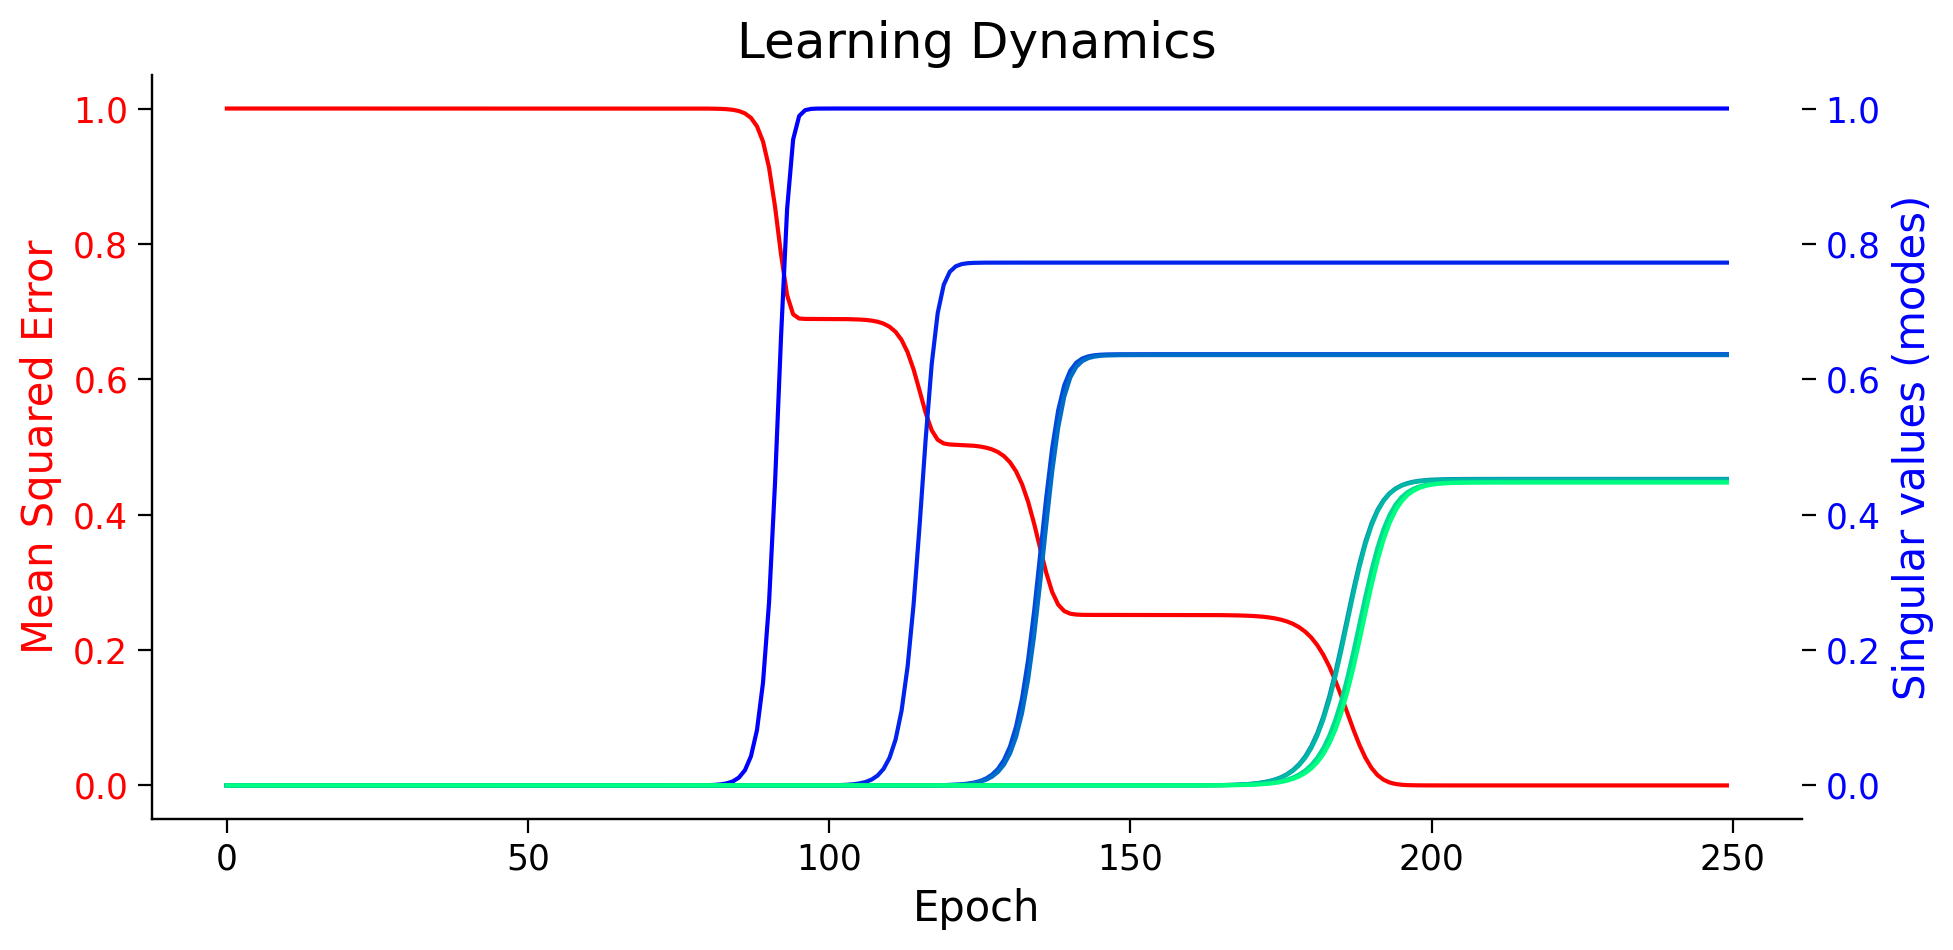

In [48]:
# @markdown #### Make sure you execute this cell to train the network and plot

lr = 100.0  # Learning rate
gamma = 1e-12  # Initialization scale
n_epochs = 250  # Number of epochs
dim_input = 8  # Input dimension = `label_tensor.size(1)`
dim_hidden = 30  # Hidden neurons
dim_output = 10000  # Output dimension = `feature_tensor.size(1)`

# Model instantiation
dlnn_model = LNNet(dim_input, dim_hidden, dim_output)

# Weights re-initialization
initializer_(dlnn_model, gamma)

# Training
losses, modes, *_ = train(dlnn_model,
                          label_tensor,
                          feature_tensor,
                          n_epochs=n_epochs,
                          lr=lr)

plot_loss_sv_twin(losses, modes)

**Think!**

In EigenValue decomposition, the amount of variance explained by eigenvectors is proportional to the corresponding eigenvalues. What about the SVD? We see that the gradient descent guides the network to first learn the features that carry more information (have higher singular value)!

In [ ]:
# @title Video 3: SVD - Discussion
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'JEbRPPG2kUI'), ('Bilibili', 'BV1t54y1J7Tb')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

---
# Section 3: Representational Similarity Analysis (RSA)

*Time estimate: ~20 mins*

In [ ]:
# @title Video 4: RSA
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'YOs1yffysX8'), ('Bilibili', 'BV19f4y157zD')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

The previous section ended with an interesting remark. SVD helped to break our deep "wide" linear neural net into 8 deep "narrow" linear neural nets.

The first narrow net (highest singular value) converges fastest, while the last four narrow nets, converge almost simultaneously and have the smallest singular values. Can it be that the narrow net with larger mode is learning the difference between "living things" and "objects", while another narrow net with smaller mode is learning the difference between Fish and Birds? how could we check this hypothesis?

Representational Similarity Analysis (RSA) is an approach that could help us understand the internal representation of our network. The main idea is that the activity of hidden units (neurons) in the network must be similar when the network is presented with similar input. For our dataset (hierarchically structured data), we expect the activity of neurons in the hidden layer to be more similar for Tuna and Canary, and less similar for Tuna and Oak.

For similarity measure, we can use the good old dot (scalar) product, which is also called cosine similarity. For calculating the dot product between multiple vectors (which would be our case), we can simply use matrix multiplication. Therefore the Representational Similarity Matrix for multiple-input (batch) activity could be calculated as follow:

\begin{equation}
RSM = \mathbf{H} \mathbf{H}^{\top}
\end{equation}

where $\mathbf{H} = \mathbf{X} \mathbf{W_1}$ is the activity of hidden neurons for a given batch $\mathbf{X}$.

## Coding Exercise 3: RSA (Optional)

The task is simple. We would need to measure the similarity between hidden layer activities $~\mathbf{h} =  \mathbf{x} ~\mathbf{W_1}$) for every input $\mathbf{x}$.

If we perform RSA in every iteration, we could also see the evolution of representation learning.

In [50]:
def ex_net_rsm(h):
  """
  Calculates the Representational Similarity Matrix

  Arg:
    h: torch.Tensor
      Activity of a hidden layer

  Returns:
    rsm: torch.Tensor
      Representational Similarity Matrix
  """
  rsm = h @ h.T
  return rsm


## Uncomment and run
test_net_rsm_ex(SEED)

Well done! Seems to be correct!


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W1D2_LinearDeepLearning/solutions/W1D2_Tutorial3_Solution_322ede5f.py)



Now we can train the model while recording the losses, modes, and RSMs at every iteration. First, use the epoch slider to explore the evolution of RSM without changing default lr ($\eta$) and initialization ($\gamma$). Then, as we did before, set $\eta$ and $\gamma$ to larger values to see whether you can retrieve the sequential structured learning of representations.

In [51]:
#@markdown #### Make sure you execute this cell to enable widgets

def loss_svd_rsm_lr_gamma(lr, gamma, i_ep):
  """
  Widget to record loss/mode/RSM at every iteration

  Args:
    lr: float
      Learning rate
    gamma: float
      Initialization scale
    i_ep: int
      Which epoch to show

  Returns:
    Nothing
  """
  n_epochs = 250  # Number of epochs
  dim_input = 8  # Input dimension = `label_tensor.size(1)`
  dim_hidden = 30  # Hidden neurons
  dim_output = 10000  # Output dimension = `feature_tensor.size(1)`

  # Model instantiation
  dlnn_model = LNNet(dim_input, dim_hidden, dim_output)

  # Weights re-initialization
  initializer_(dlnn_model, gamma)

  # Training
  losses, modes, rsms, _ = train(dlnn_model,
                                 label_tensor,
                                 feature_tensor,
                                 n_epochs=n_epochs,
                                 lr=lr)
  plot_loss_sv_rsm(losses, modes, rsms, i_ep)

i_ep_slider = IntSlider(min=10, max=241, step=1, value=61,
                        continuous_update=False,
                        description='Epoch',
                        layout=Layout(width='630px'))

lr_slider = FloatSlider(min=20.0, max=200.0, step=1.0, value=100.0,
                        continuous_update=False,
                        readout_format='.1f',
                        description='eta')

gamma_slider = FloatLogSlider(min=-15, max=1, step=1,
                              value=1e-12, base=10,
                              continuous_update=False,
                              description='gamma')

widgets_ui = VBox([lr_slider, gamma_slider, i_ep_slider])

widgets_out = interactive_output(loss_svd_rsm_lr_gamma,
                                 {'lr': lr_slider,
                                  'gamma': gamma_slider,
                                  'i_ep': i_ep_slider})

display(widgets_ui, widgets_out)

Output()

Let's take a moment to analyze this more. A deep neural net is learning the representations, rather than a naive mapping (look-up table). This is thought to be the reason for deep neural nets supreme generalization and transfer learning ability. Unsurprisingly, neural nets with no hidden layer are incapable of representation learning, even with extremely small initialization.

In [ ]:
# @title Video 5: RSA - Discussion
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'vprldATyq1o'), ('Bilibili', 'BV18y4y1j7Xr')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

---
# Section 4: Illusory Correlations

*Time estimate: ~20-30 mins*

In [ ]:
# @title Video 6: Illusory Correlations
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'RxsAvyIoqEo'), ('Bilibili', 'BV1vv411E7Sq')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

Let's recall the training loss curves. There was often a long plateau (where the weights are stuck at a saddle point), followed by a sudden drop. For very deep complex neural nets, such plateaus can take hours of training, and we are often tempted to stop the training, because we believe it is "as good as it gets"! Another side effect of "immature interruption" of training is the network finding (learning) illusory correlations.

To better understand this, let's do the next demonstration and exercise.

## Demonstration: Illusory Correlations

Our original dataset has 4 animals: Canary, Robin, Goldfish, and Tuna. These animals all have bones. Therefore if we include a "has bone" feature, the network would learn it at the second level (i.e. second bump, second mode convergence), when it learns the animal-plants distinction.

What if the dataset has Shark instead of Goldfish. Sharks don't have bones (their skeletons are made of cartilaginous, which is much lighter than true bone and more flexible). Then we will have a feature which is *True* (i.e. +1) for Tuna, Robin, and Canary, but *False* (i.e. -1) for all the plants and the shark! Let's see what the network does.

First, we add the new feature to the targets. We then start training our LNN and in every epoch, record the network prediction for "sharks having bones".

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W1D2_LinearDeepLearning/static/shark_tree.png" alt="Simple nn graph" width="600"/></center>

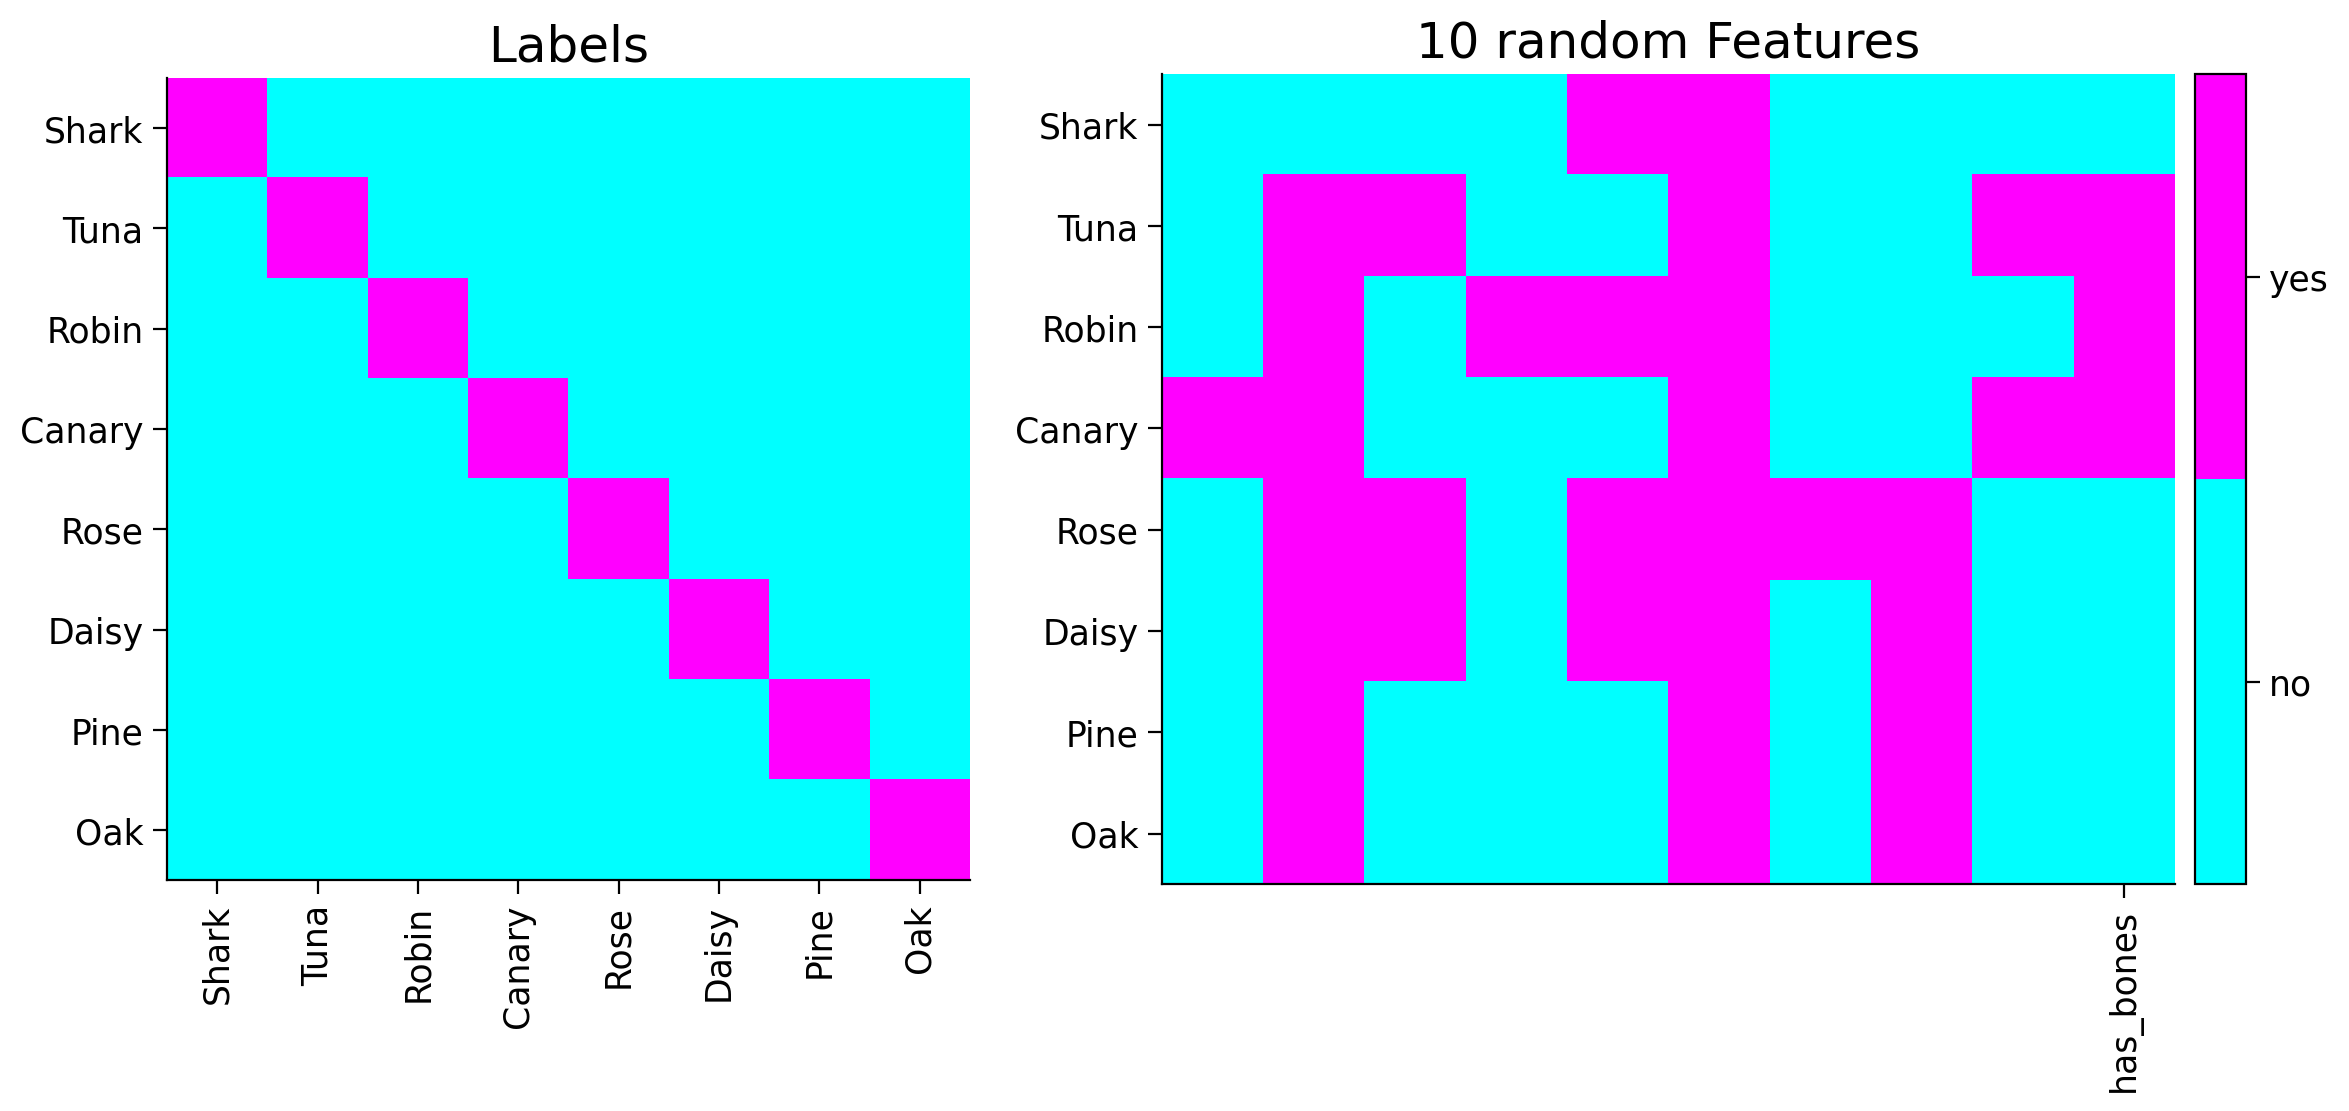

In [52]:
# Sampling new data from the tree
tree_labels, tree_features = generate_hsd()

# Replacing Goldfish with Shark
item_names = ['Shark', 'Tuna', 'Robin', 'Canary',
              'Rose', 'Daisy', 'Pine', 'Oak']

# Index of label to record
illusion_idx = 0  # Shark is the first element

# The new feature (has bones) vector
new_feature = [-1, 1, 1, 1, -1, -1, -1, -1]
its_label = 'has_bones'

# Adding feature has_bones to the feature array
tree_features = add_feature(tree_features, new_feature)

# Plotting
plot_tree_data(item_names, tree_features, its_label)

You can see the new feature shown in the last column of the plot above.

Now we can train the network on the new data, and record the network prediction (output) for Shark (indexed 0) label and "has bone" feature (last feature, indexed -1), during the training.

Here is the snippet from the training loop that keeps track of network prediction for `illusory_i`th label and last (`-1`) feature:

```python
pred_ij = predictions.detach()[illusory_i, -1]
```

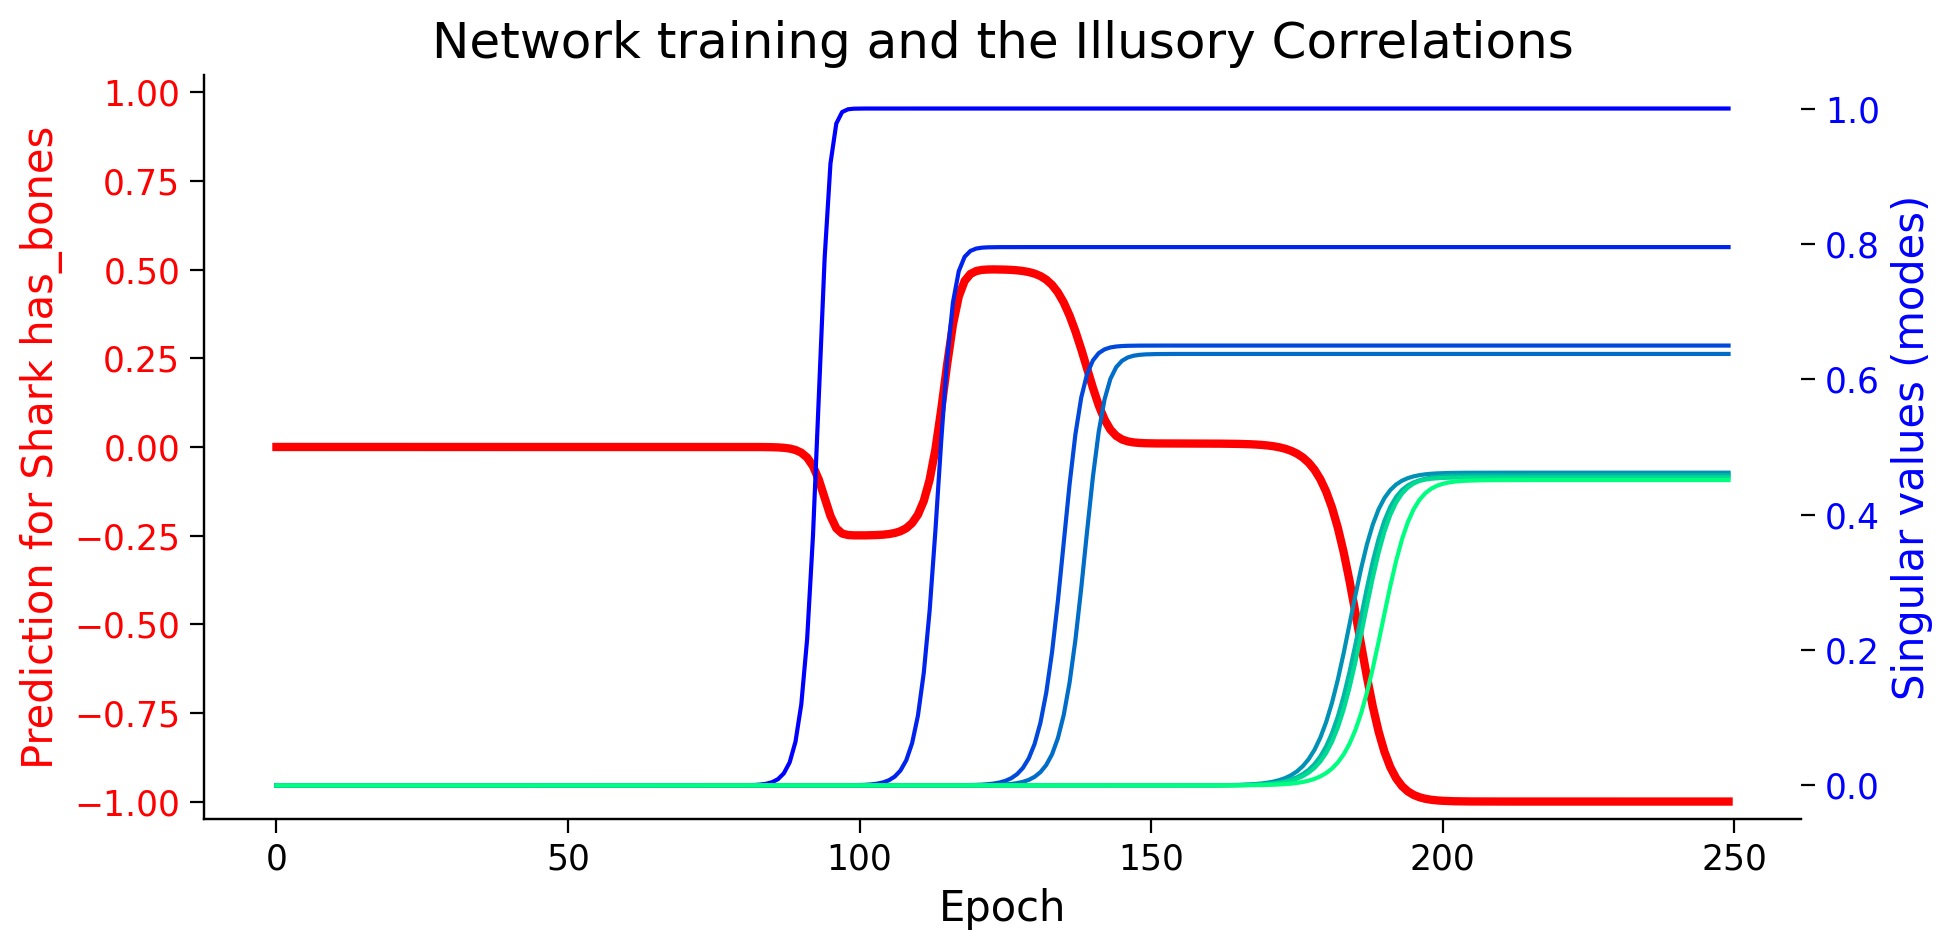

In [53]:
#@markdown #### Make sure you execute this cell to train the network and plot

# Convert (cast) data from np.ndarray to torch.Tensor
label_tensor = torch.tensor(tree_labels).float()
feature_tensor = torch.tensor(tree_features).float()

lr = 100.0  # Learning rate
gamma = 1e-12  # Initialization scale
n_epochs = 250  # Number of epochs
dim_input = 8  # Input dimension = `label_tensor.size(1)`
dim_hidden = 30  # Hidden neurons
dim_output = feature_tensor.size(1)

# Model instantiation
dlnn_model = LNNet(dim_input, dim_hidden, dim_output)

# Weights re-initialization
initializer_(dlnn_model, gamma)

# Training
_, modes, _, ill_predictions = train(dlnn_model,
                                     label_tensor,
                                     feature_tensor,
                                     n_epochs=n_epochs,
                                     lr=lr,
                                     illusory_i=illusion_idx)

# Label for the plot
ill_label = f"Prediction for {item_names[illusion_idx]} {its_label}"

# Plotting
plot_ills_sv_twin(ill_predictions, modes, ill_label)

It seems that the network starts by learning an "illusory correlation" that sharks have bones, and in later epochs, as it learns deeper representations, it can see (learn) beyond the illusory correlation. This is important to remember that we never presented the network with any data saying that sharks have bones.

## Exercise 4: Illusory Correlations

This exercise is just for you to explore the idea of illusory correlations. Think of medical, natural, or possibly social illusory correlations which can test the learning power of deep linear neural nets.

**important notes**: the generated data is independent of tree labels, therefore the names are just for convenience.

Here is our example for **Non-human Living things do not speak**. The lines marked by `{edit}` are for you to change in your example.

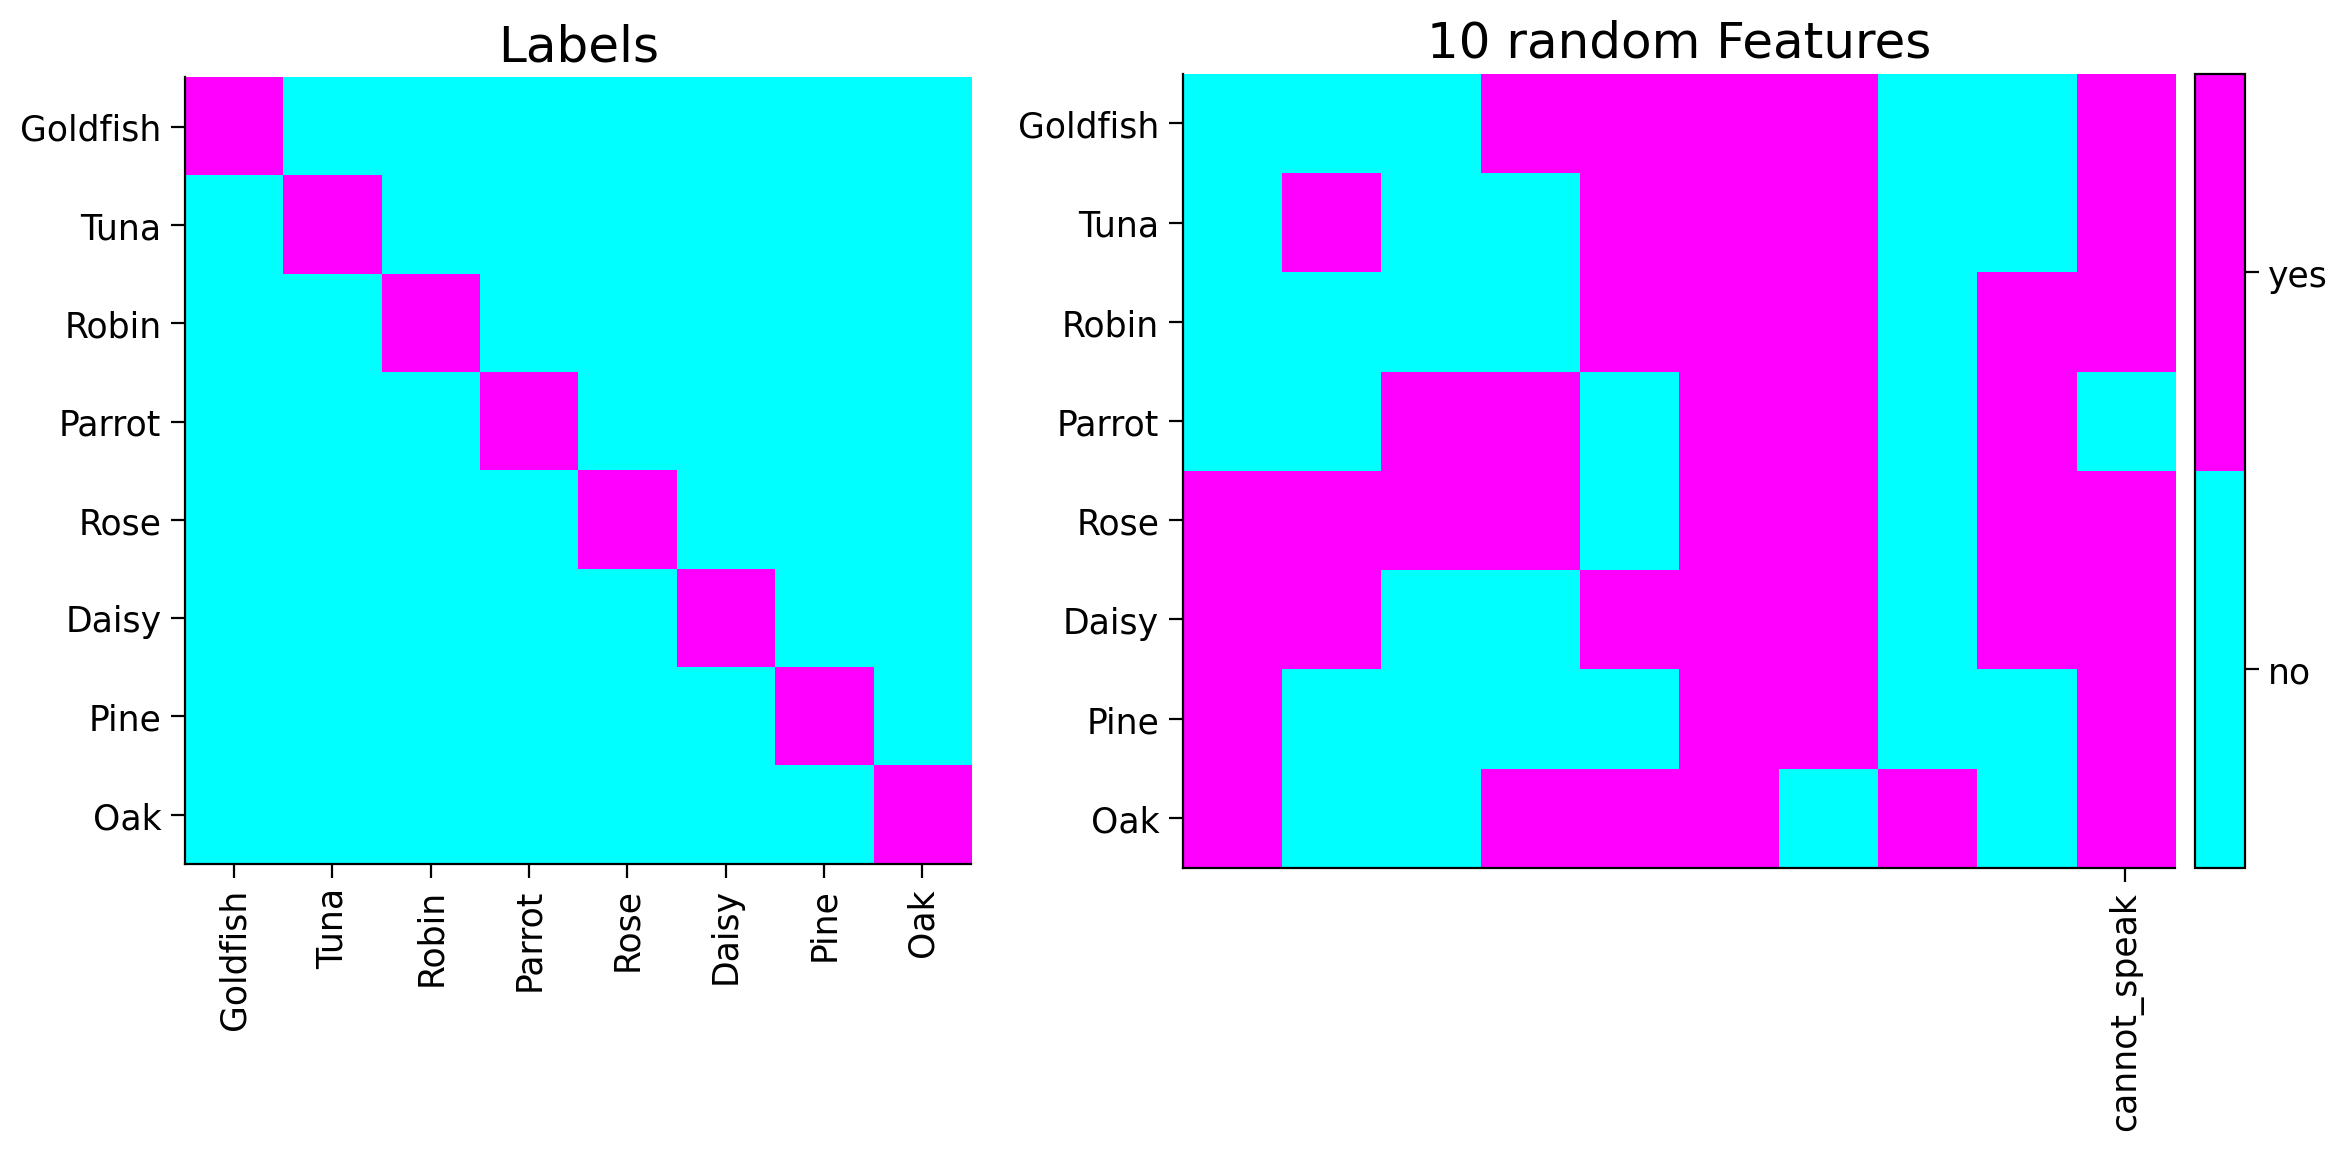

In [54]:
# Sampling new data from the tree
tree_labels, tree_features = generate_hsd()

# {edit} Replacing Canary with Parrot
item_names = ['Goldfish', 'Tuna', 'Robin', 'Parrot',
              'Rose', 'Daisy', 'Pine', 'Oak']

# {edit} Index of label to record
illusion_idx = 3  # Parrot is the fourth element

# {edit} The new feature (cannot speak) vector
new_feature = [1, 1, 1, -1, 1, 1, 1, 1]
its_label = 'cannot_speak'

# Adding feature has_bones to the feature array
tree_features = add_feature(tree_features, new_feature)

# Plotting
plot_tree_data(item_names, tree_features, its_label)

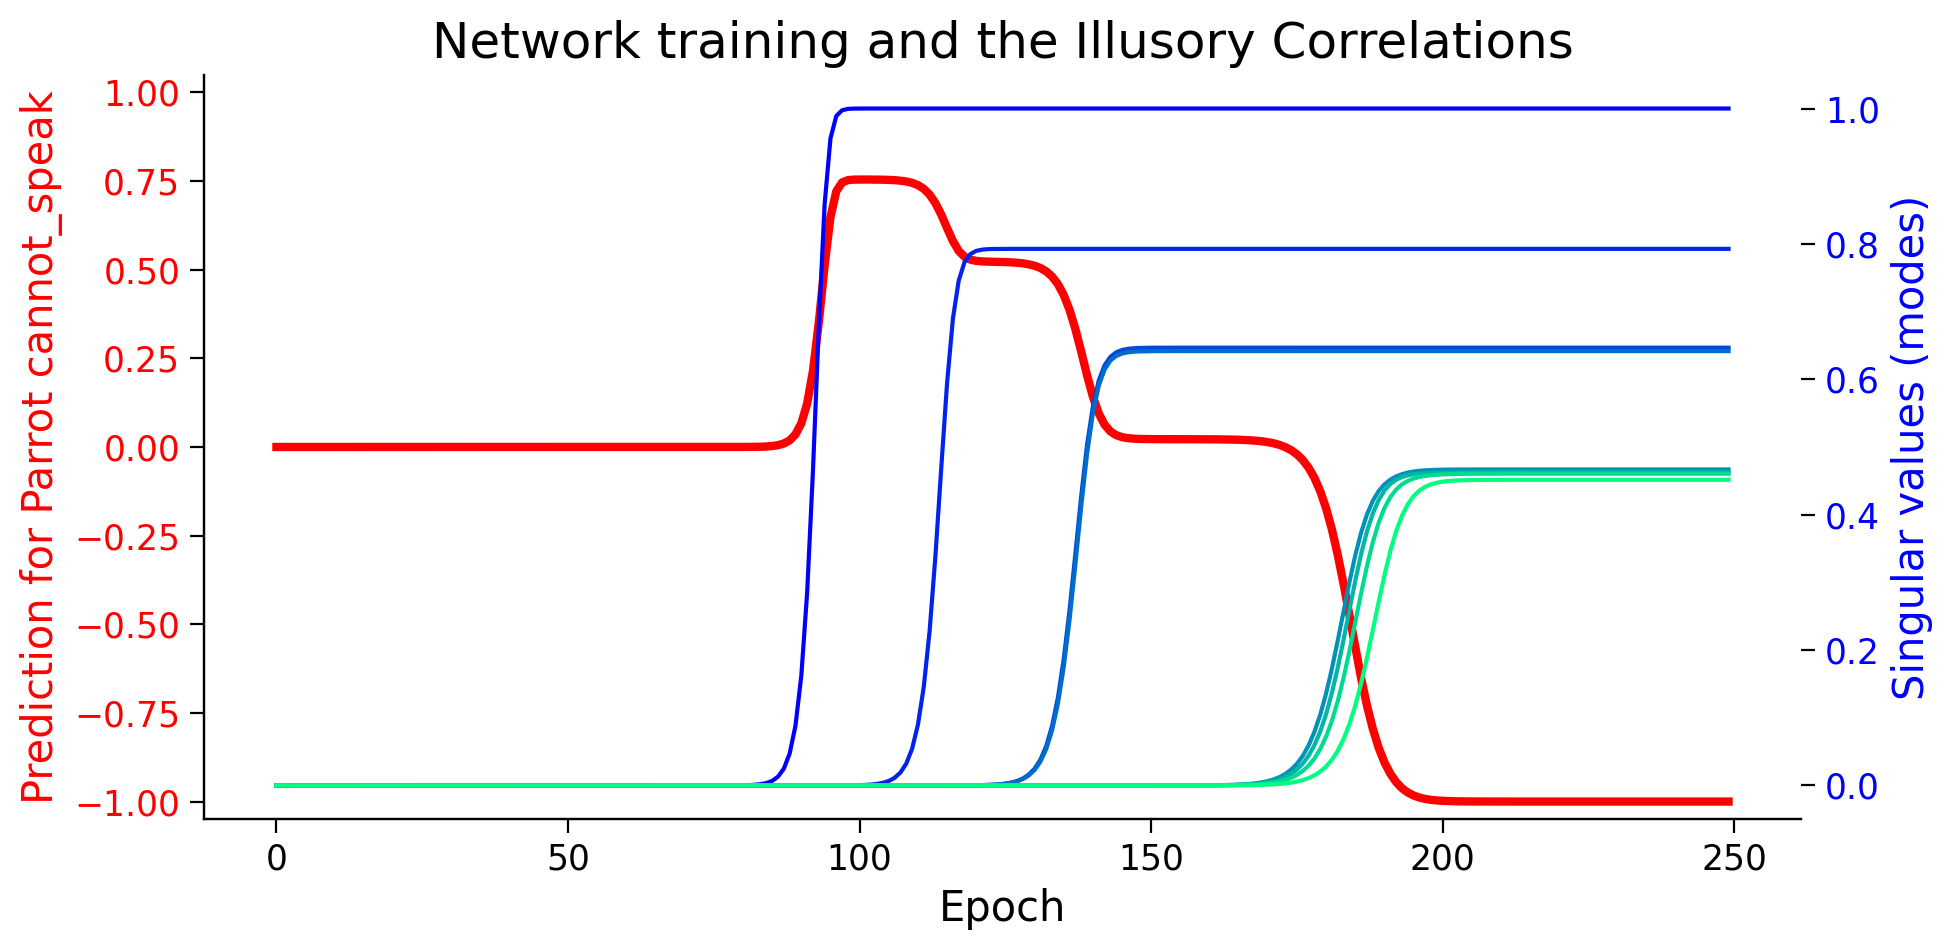

In [55]:
# @markdown #### Make sure you execute this cell to train the network and plot

# Convert (cast) data from np.ndarray to torch.Tensor
label_tensor = torch.tensor(tree_labels).float()
feature_tensor = torch.tensor(tree_features).float()

lr = 100.0  # Learning rate
gamma = 1e-12  # Initialization scale
n_epochs = 250  # Number of epochs
dim_input = 8  # Input dimension = `label_tensor.size(1)`
dim_hidden = 30  # Hidden neurons
dim_output = feature_tensor.size(1)

# Model instantiation
dlnn_model = LNNet(dim_input, dim_hidden, dim_output)

# Weights re-initialization
initializer_(dlnn_model, gamma)

# Training
_, modes, _, ill_predictions = train(dlnn_model,
                                     label_tensor,
                                     feature_tensor,
                                     n_epochs=n_epochs,
                                     lr=lr,
                                     illusory_i=illusion_idx)

# Label for the plot
ill_label = f"Prediction for {item_names[illusion_idx]} {its_label}"

# Plotting
plot_ills_sv_twin(ill_predictions, modes, ill_label)

In [ ]:
# @title Video 7: Illusory Correlations - Discussion
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '6VLHKQjQJmI'), ('Bilibili', 'BV1vv411E7rg')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

---
# Summary

The second day of the course has ended. So, in the third tutorial of the linear deep learning day we have learned more advanced topics. In the beginning we implemented a deep linear neural network and then we studied its learning dynamics using the linear algebra tool called singular value decomposition. Then, we learned about the representational similarity analysis and the illusory correlation.

In [ ]:
# @title Video 8: Outro
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'N2szOIsKyXE'), ('Bilibili', 'BV1AL411n7ns')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

---
# Bonus

*Time estimate: ~20-30 mins*

In [ ]:
# @title Video 9: Linear Regression
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'uULOAbhYaaE'), ('Bilibili', 'BV1Pf4y1L71L')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

## Section 5.1: Linear Regression

Generally, *regression* refers to a set of methods for modeling the mapping (relationship) between one (or more) independent variable(s) (i.e., features) and one (or more) dependent variable(s) (i.e., labels). For example, if we want to examine the relative impacts of calendar date, GPS coordinates, and time of the day (the independent variables) on air temperature (the dependent variable). On the other hand, regression can be used for predictive analysis. Thus the independent variables are also called predictors. When the model contains more than one predictor, then the method is called *multiple regression*, and if it contains more than one dependent variable called *multivariate regression*. Regression problems pop up whenever we want to predict a numerical (usually continuous) value.

The independent variables are collected in vector $\mathbf{x} \in \mathbb{R}^M$, where $M$ denotes the number of independent variables, while the dependent variables are collected in vector $\mathbf{y} \in \mathbb{R}^N$, where $N$ denotes the number of dependent variables. And the mapping between them is represented by the weight matrix $\mathbf{W} \in \mathbb{R}^{N \times M}$ and a bias vector $\mathbf{b} \in \mathbb{R}^{N}$ (generalizing to affine mappings).

The multivariate regression model can be written as:

\begin{equation}
\mathbf{y} = \mathbf{W} ~ \mathbf{x} + \mathbf{b}
\end{equation}

or it can be written in matrix format as:

\begin{equation}
\begin{bmatrix} y_{1} \\ y_{2} \\ \vdots \\ y_{N} \\ \end{bmatrix} = \begin{bmatrix} w_{1,1} & w_{1,2} & \dots & w_{1,M} \\ w_{2,1} & w_{2,2} & \dots & w_{2,M} \\ \vdots & \ddots & \ddots & \vdots \\ w_{N,1} & w_{N,2} & \dots & w_{N,M} \end{bmatrix} \begin{bmatrix} x_{1} \\ x_{2} \\ \vdots \\ x_{M} \\ \end{bmatrix} + \begin{bmatrix} b_{1} \\ b_{2} \\ \vdots \\b_{N} \\ \end{bmatrix}
\end{equation}

## Section 5.2: Vectorized regression

Linear regression can be simply extended to multi-samples ($D$) input-output mapping, which we can collect in a matrix $\mathbf{X} \in \mathbb{R}^{M \times D}$, sometimes called the design matrix. The sample dimension also shows up in the output matrix $\mathbf{Y} \in \mathbb{R}^{N \times D}$. Thus, linear regression takes the following form:

\begin{equation}
\mathbf{Y} = \mathbf{W} ~ \mathbf{X} + \mathbf{b}
\end{equation}

where matrix $\mathbf{W} \in \mathbb{R}^{N \times M}$ and the vector $\mathbf{b} \in \mathbb{R}^{N}$ (broadcasted over sample dimension) are the desired parameters to find.

## Section 5.3: Analytical Linear Regression

Linear regression is a relatively simple optimization problem. Unlike most other models that we will see in this course, linear regression for mean squared loss can be solved analytically.

For $D$ samples (batch size), $\mathbf{X} \in \mathbb{R}^{M \times D}$, and $\mathbf{Y} \in \mathbb{R}^{N \times D}$, the goal of linear regression is to find $\mathbf{W} \in \mathbb{R}^{N \times M}$ such that:

\begin{equation}
\mathbf{Y} = \mathbf{W} ~ \mathbf{X}
\end{equation}

Given the Squared Error loss function, we have:

\begin{equation}
Loss(\mathbf{W}) = ||\mathbf{Y} - \mathbf{W} ~ \mathbf{X}||^2
\end{equation}

So, using matrix notation, the optimization problem is given by:

\begin{align}
\mathbf{W^{*}} &= \underset{\mathbf{W}}{\mathrm{argmin}} \left( Loss (\mathbf{W})  \right) \\
 &= \underset{\mathbf{W}}{\mathrm{argmin}} \left( ||\mathbf{Y} - \mathbf{W} ~ \mathbf{X}||^2  \right) \\
&= \underset{\mathbf{W}}{\mathrm{argmin}} \left( \left( \mathbf{Y} - \mathbf{W} ~ \mathbf{X}\right)^{\top} \left( \mathbf{Y} - \mathbf{W} ~ \mathbf{X}\right) \right)
\end{align}

To solve the minimization problem, we can simply set the derivative of the loss with respect to $\mathbf{W}$ to zero.

\begin{equation}
\dfrac{\partial Loss}{\partial \mathbf{W}} = 0
\end{equation}

Assuming that $\mathbf{X}\mathbf{X}^{\top}$ is full-rank, and thus it is invertible, we can write:

\begin{equation}
\mathbf{W}^{\mathbf{*}} = \mathbf{Y} \mathbf{X}^{\top} \left( \mathbf{X}  \mathbf{X}^{\top} \right) ^{-1}
\end{equation}

<br>

**Note:** The $||\cdot||$ denotes the norm 2 or the Euclidean norm of a vector.

### Coding Exercise 5.3.1: Analytical solution to LR

Complete the function `linear_regression` for finding the analytical solution to linear regression.

In [60]:
def linear_regression(X, Y):
  """
  Analytical Linear regression

  Args:
    X: np.ndarray
      Design matrix
    Y: np.ndarray
      Target ouputs

  Returns:
    W: np.ndarray
      Estimated weights (mapping)
  """
  assert isinstance(X, np.ndarray)
  assert isinstance(Y, np.ndarray)
  M, Dx = X.shape
  N, Dy = Y.shape
  assert Dx == Dy

  W = Y @ X.T @ np.linalg.inv(X @ X.T)

  return W


W_true = np.random.randint(low=0, high=10, size=(3, 3)).astype(float)

X_train = np.random.rand(3, 37)  # 37 samples
noise = np.random.normal(scale=0.01, size=(3, 37))
Y_train = W_true @ X_train + noise

## Uncomment and run
W_estimate = linear_regression(X_train, Y_train)
print(f"True weights:\n {W_true}")
print(f"\nEstimated weights:\n {np.round(W_estimate, 1)}")

True weights:
 [[3. 4. 5.]
 [6. 3. 2.]
 [1. 5. 9.]]

Estimated weights:
 [[3. 4. 5.]
 [6. 3. 2.]
 [1. 5. 9.]]


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W1D2_LinearDeepLearning/solutions/W1D2_Tutorial3_Solution_aa3d6993.py)



## Demonstration: Linear Regression vs. DLNN

A linear neural network with NO hidden layer is very similar to linear regression in its core. We also know that no matter how many hidden layers a linear network has, it can be compressed to linear regression (no hidden layers).

In this demonstration, we use the hierarchically structured data to:

* analytically find the mapping between features and labels
* train a zero-depth LNN to find the mapping
* compare them to the $W_{tot}$ from the already trained deep LNN

In [61]:
# Sampling new data from the tree
tree_labels, tree_features = generate_hsd()

# Convert (cast) data from np.ndarray to torch.Tensor
label_tensor = torch.tensor(tree_labels).float()
feature_tensor = torch.tensor(tree_features).float()

In [62]:
# Calculating the W_tot for deep network (already trained model)

lr = 100.0  # Learning rate
gamma = 1e-12  # Initialization scale
n_epochs = 250  # Number of epochs
dim_input = 8  # Input dimension = `label_tensor.size(1)`
dim_hidden = 30  # Hidden neurons
dim_output = 10000  # Output dimension = `feature_tensor.size(1)`

# Model instantiation
dlnn_model = LNNet(dim_input, dim_hidden, dim_output)

# Weights re-initialization
initializer_(dlnn_model, gamma)

# Training
losses, modes, rsms, ills = train(dlnn_model,
                                  label_tensor,
                                  feature_tensor,
                                  n_epochs=n_epochs,
                                  lr=lr)

deep_W_tot = torch.eye(dim_input)
for weight in dlnn_model.parameters():
  deep_W_tot = weight @ deep_W_tot
deep_W_tot = deep_W_tot.detach().numpy()

In [63]:
# Analytically estimation of weights
# First dimension of data is `batch`, so we need to transpose our data
analytical_weights = linear_regression(tree_labels.T, tree_features.T)

In [64]:
class LRNet(nn.Module):
  """
  A Linear Neural Net with ZERO hidden layer (LR net)
  """

  def __init__(self, in_dim, out_dim):
    """
    Initialize LRNet

    Args:
      in_dim: int
        Input dimension
      hid_dim: int
        Hidden dimension

    Returns:
      Nothing
    """
    super().__init__()
    self.in_out = nn.Linear(in_dim, out_dim, bias=False)

  def forward(self, x):
    """
    Forward pass of LRNet

    Args:
      x: torch.Tensor
        Input tensor

    Returns:
      out: torch.Tensor
        Output/Prediction
    """
    out = self.in_out(x)  # Output (Prediction)
    return out

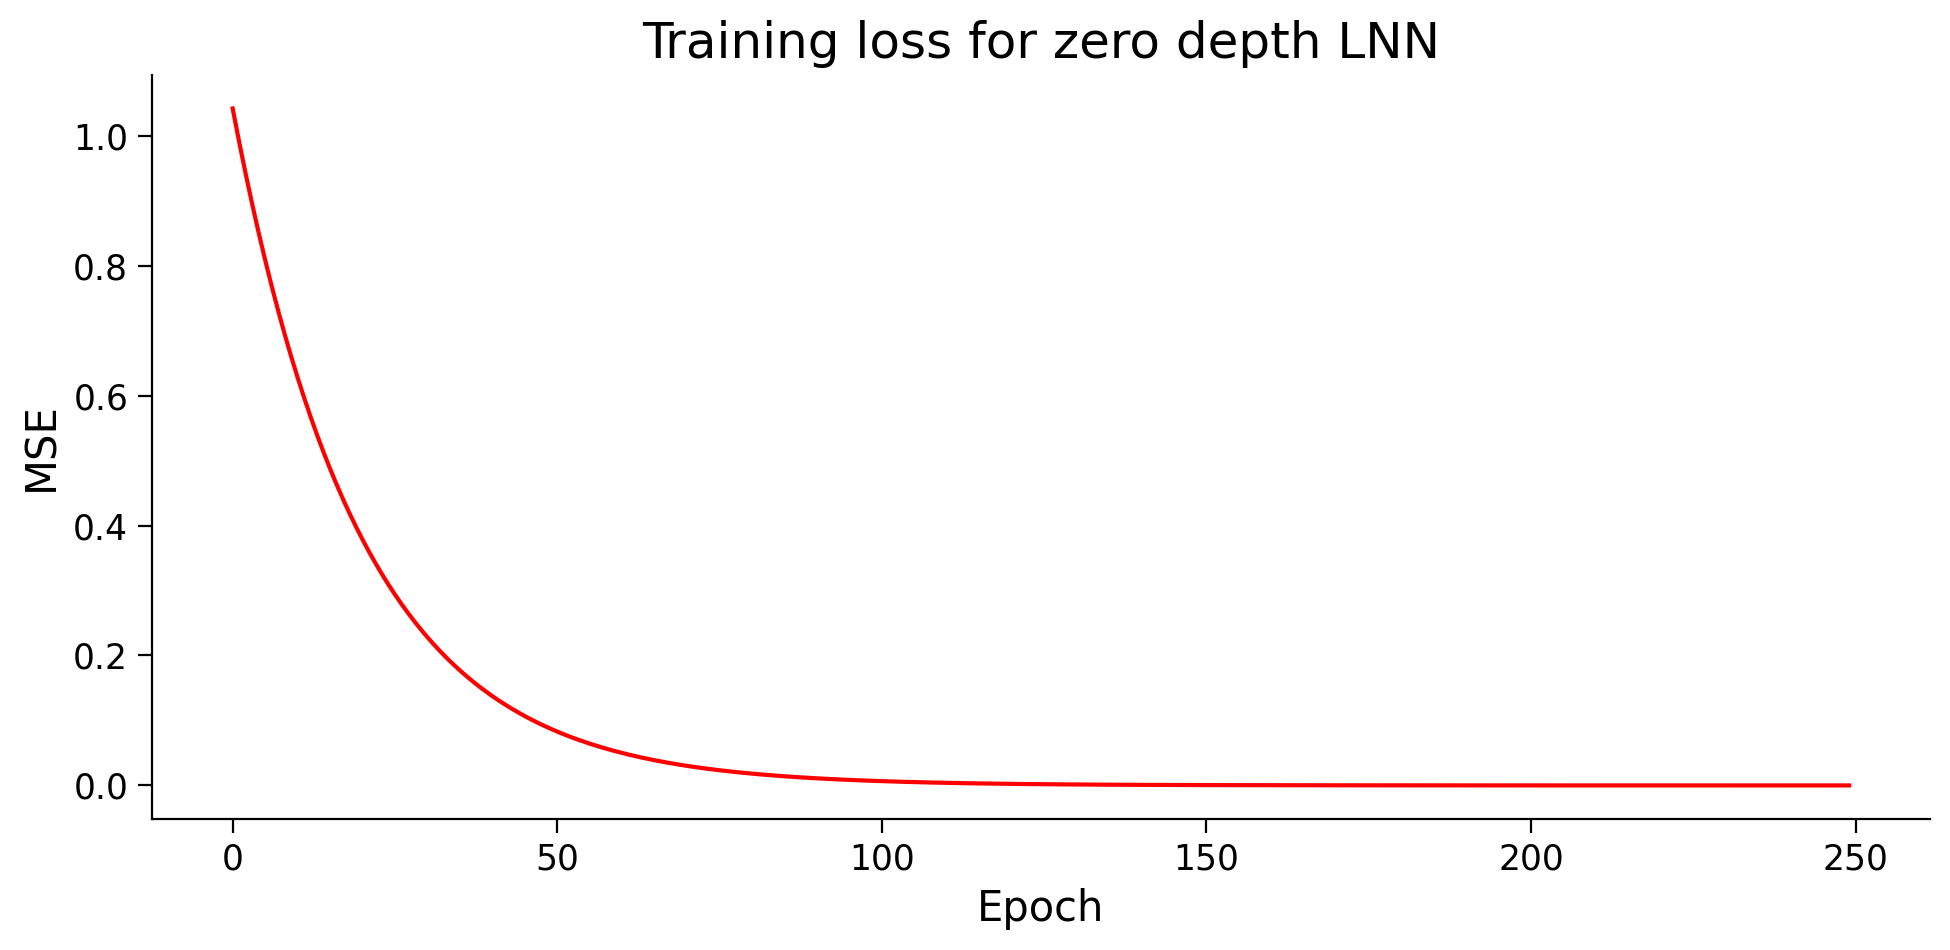

In [65]:
lr = 1000.0  # Learning rate
gamma = 1e-12  # Initialization scale
n_epochs = 250  # Number of epochs
dim_input = 8  # Input dimension = `label_tensor.size(1)`
dim_output = 10000  # Output dimension = `feature_tensor.size(1)`

# Model instantiation
LR_model = LRNet(dim_input, dim_output)
optimizer = optim.SGD(LR_model.parameters(), lr=lr)
criterion = nn.MSELoss()

losses = np.zeros(n_epochs)  # Loss records
for i in range(n_epochs):  # Training loop
  optimizer.zero_grad()
  predictions = LR_model(label_tensor)
  loss = criterion(predictions, feature_tensor)
  loss.backward()
  optimizer.step()
  losses[i] = loss.item()

# Trained weights from zero_depth_model
LR_model_weights = next(iter(LR_model.parameters())).detach().numpy()

plot_loss(losses, "Training loss for zero depth LNN", c="r")

In [66]:
print("The final weights from all methods are approximately equal?! "
"{}!".format(
  (np.allclose(analytical_weights, LR_model_weights, atol=1e-02) and \
   np.allclose(analytical_weights, deep_W_tot, atol=1e-02))
  )
)

The final weights from all methods are approximately equal?! True!


As you may have guessed, they all arrive at the same results but through very different paths.

In [ ]:
# @title Video 10: Linear Regression - Discussion
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'gG15_J0i05Y'), ('Bilibili', 'BV18v411E7Wg')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)